# Data Wrangling
ในบทนี้ จะเป็นการแนะนำการทำ Data Wrangling หรือการเตรียมข้อมูล ด้วยภาษา `R`

# Install and Load packages

In [ ]:
# if running on google colab
# system("
#   apt-get install -y libudunits2-dev
#   apt-get install -y libgdal-dev
#   apt-get install -y gdal-bin
#   apt-get install -y libgeos-dev
#   apt-get install -y libproj-dev
#   apt-get install -y libicu-dev
#   apt-get install -y libcurl4-openssl-dev
#   apt-get install -y libssl-dev
#   apt-get install -y zlib1g-dev
#   apt-get install -y libfontconfig1-dev
#   apt-get install -y libfreetype6-dev
#   apt-get install -y libcairo2-dev
#   apt-get install -y pandoc
#   ")

In [55]:
options("repos" = "https://packagemanager.rstudio.com/cran/__linux__/bionic/latest/")
install.packages("RPostgres")
install.packages("sf")
install.packages("leaflet")
install.packages("treemapify")
install.packages("gganimate")
install.packages("ggalluvial")
install.packages("ggsci")
install.packages("hrbrthemes")

Warning message:
"package 'RPostgres' is in use and will not be installed"
Warning message:
"package 'sf' is in use and will not be installed"


package 'leaflet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Acer\AppData\Local\Temp\RtmpeKyIYt\downloaded_packages


Warning message:
"package 'treemapify' is in use and will not be installed"
Warning message:
"package 'gganimate' is in use and will not be installed"
Warning message:
"package 'ggalluvial' is in use and will not be installed"
Warning message:
"package 'ggsci' is in use and will not be installed"


In [71]:
options(scipen = 999)
library(tidyverse)
library(DBI)
library(RPostgres)
library(sf)
library(leaflet)
library(treemapify)
library(gganimate)
library(ggalluvial)
library(ggsci)
library(plotly)
library(hrbrthemes)

# Load Data

## setting path

In [1]:
getwd()

[1] "C:/Users/Acer/Google Drive/workshop/2021-08-24_introR/notebook"

In [2]:
setwd("..")
getwd()

[1] "C:/Users/Acer/Google Drive/workshop/2021-08-24_introR"

## disk

In [3]:
df <- readRDS("data/production_oae.rds")
tha1 <- readRDS("data/tha_adm1_sim.rds")

## database

In [11]:
conn <- dbConnect(
  RPostgres::Postgres(),
  host = "192.168.4.133",
  user = "oae_user",
  password = "p@ssword",
  dbname = "db_nabc",
  options="-c search_path=production"
)

In [12]:
dbListTables(conn)

[1] "production_usda"       "production_oae_y_wide"

In [14]:
df <- dbReadTable(conn, "production_oae_y_wide")
dbDisconnect(conn)

In [6]:
conn <- dbConnect(
  RPostgres::Postgres(),
  host = "192.168.4.133",
  user = "oae_user",
  password = "p@ssword",
  dbname = "db_nabc",
  options="-c search_path=spatial"
)

In [7]:
dbListTables(conn)

[1] "spatial_ref_sys"    "gadm_khm_3"         "gadm_khm_4"        
 [4] "gadm_lao_1"         "gadm_lao_2"         "tha_adm2"          
 [7] "gadm_khm_2"         "tha_adm3"           "tha_adm1_sim"      
[10] "tha_adm2_sim"       "tha_adm3_sim"       "tha_lines"         
[13] "tha_points"         "gadm_mmr_1"         "gadm_mmr_2"        
[16] "gadm_mmr_3"         "gadm_mys_1"         "gadm_mys_2"        
[19] "gadm_phl_1"         "gadm_phl_2"         "ne_countries_sim"  
[22] "ne_mapunits_sim"    "ne_mapsubunits_sim" "tha_adm1"          
[25] "gadm_phl_3"         "gadm_brn_1"         "gadm_brn_2"        
[28] "gadm_idn_1"         "gadm_idn_2"         "gadm_idn_3"        
[31] "gadm_idn_4"         "gadm_khm_1"         "gadm_sgp_1"        
[34] "gadm_tha_1"         "gadm_tha_2"         "gadm_tha_3"        
[37] "gadm_vnm_1"         "gadm_vnm_2"         "gadm_vnm_3"        
[40] "ne_countries"       "ne_mapunits"        "ne_mapsubunits"    
[43] "geography_columns"  "geometry_columns"

In [10]:
tha1 <- st_read(conn, "tha_adm1_sim")
dbDisconnect(conn)

# Choosing Charts
กราฟมีหลายรูปแบบ เราต้องเลือกประเภทของกราฟในการแสดงผลให้เหมาะสมกับข้อมูลและประเด็นที่ต้องการสื่อสาร

**Guideline:**
- https://www.r-graph-gallery.com  
- https://www.data-to-viz.com    
- http://ft-interactive.github.io/visual-vocabulary/
![](https://github.com/Financial-Times/chart-doctor/raw/main/visual-vocabulary/poster.png)
![](https://www.data-to-viz.com/img/poster/poster_big.png)
![](https://chart.guide/wp-content/uploads/2019/10/ChartGuide-402-1024x724.jpg)

ขอแบ่งประเภทกราฟ เป็นสองประเภท คือ Simple Charts และ Map

# Simple Charts
สามารถทำได้ทั้งแบบ static และ interactive (สามารถ interact กับ กราฟ ได้ เช่น hover, click)

## Static
R มีความโดดเด่นในการสร้าง charts และ library ที่นิยมใช้ คือ `ggplot2` พัฒนาโดย Handley Wickham โดยใช้ แนวคิด Grammar of Graphics ซึ่งมีองค์ประกอบดังนี้

- **Data**: ข้อมูลที่ใช้ในการสร้างกราฟ
- **Geometries** `geom_`: ประเภทกราฟที่จะสร้าง เช่น bar, line, point
- **Aesthetics** `aes()`: object ที่ใช้แสดงผลข้อมูล เช่น ตำแหน่ง x y color, size, shape, และ alpha (transparency)
- **Scales** `scale_`: คือ การแปลงข้อมูลของของมูลในแต่ละมิติของ aesthetic เช่น การ take log
- **Statistical transformations** `stat_`: เป็นการแปลงข้อมูล เช่น sum, fitted lines
- **Coordinate system** `coord_`: เช่น cartesian หรือ polar
- **Facets** `facet_`: การจัดวางกราฟในลักษณะ grid
- **Visual** themes theme(): การควบคุมการแสดงผล เช่น background, grid, axes, title, font, size, color เป็นต้น

ดูรายละเอียดเพิ่มเติมได้ที่ https://datavizs21.classes.andrewheiss.com/content/03-content/

In [18]:
df_rice_1 <- df %>%
  filter(subcommod == "ข้าวนาปี", !is.na(reg_oae))

- Distribution (Histrogram, Boxplot)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



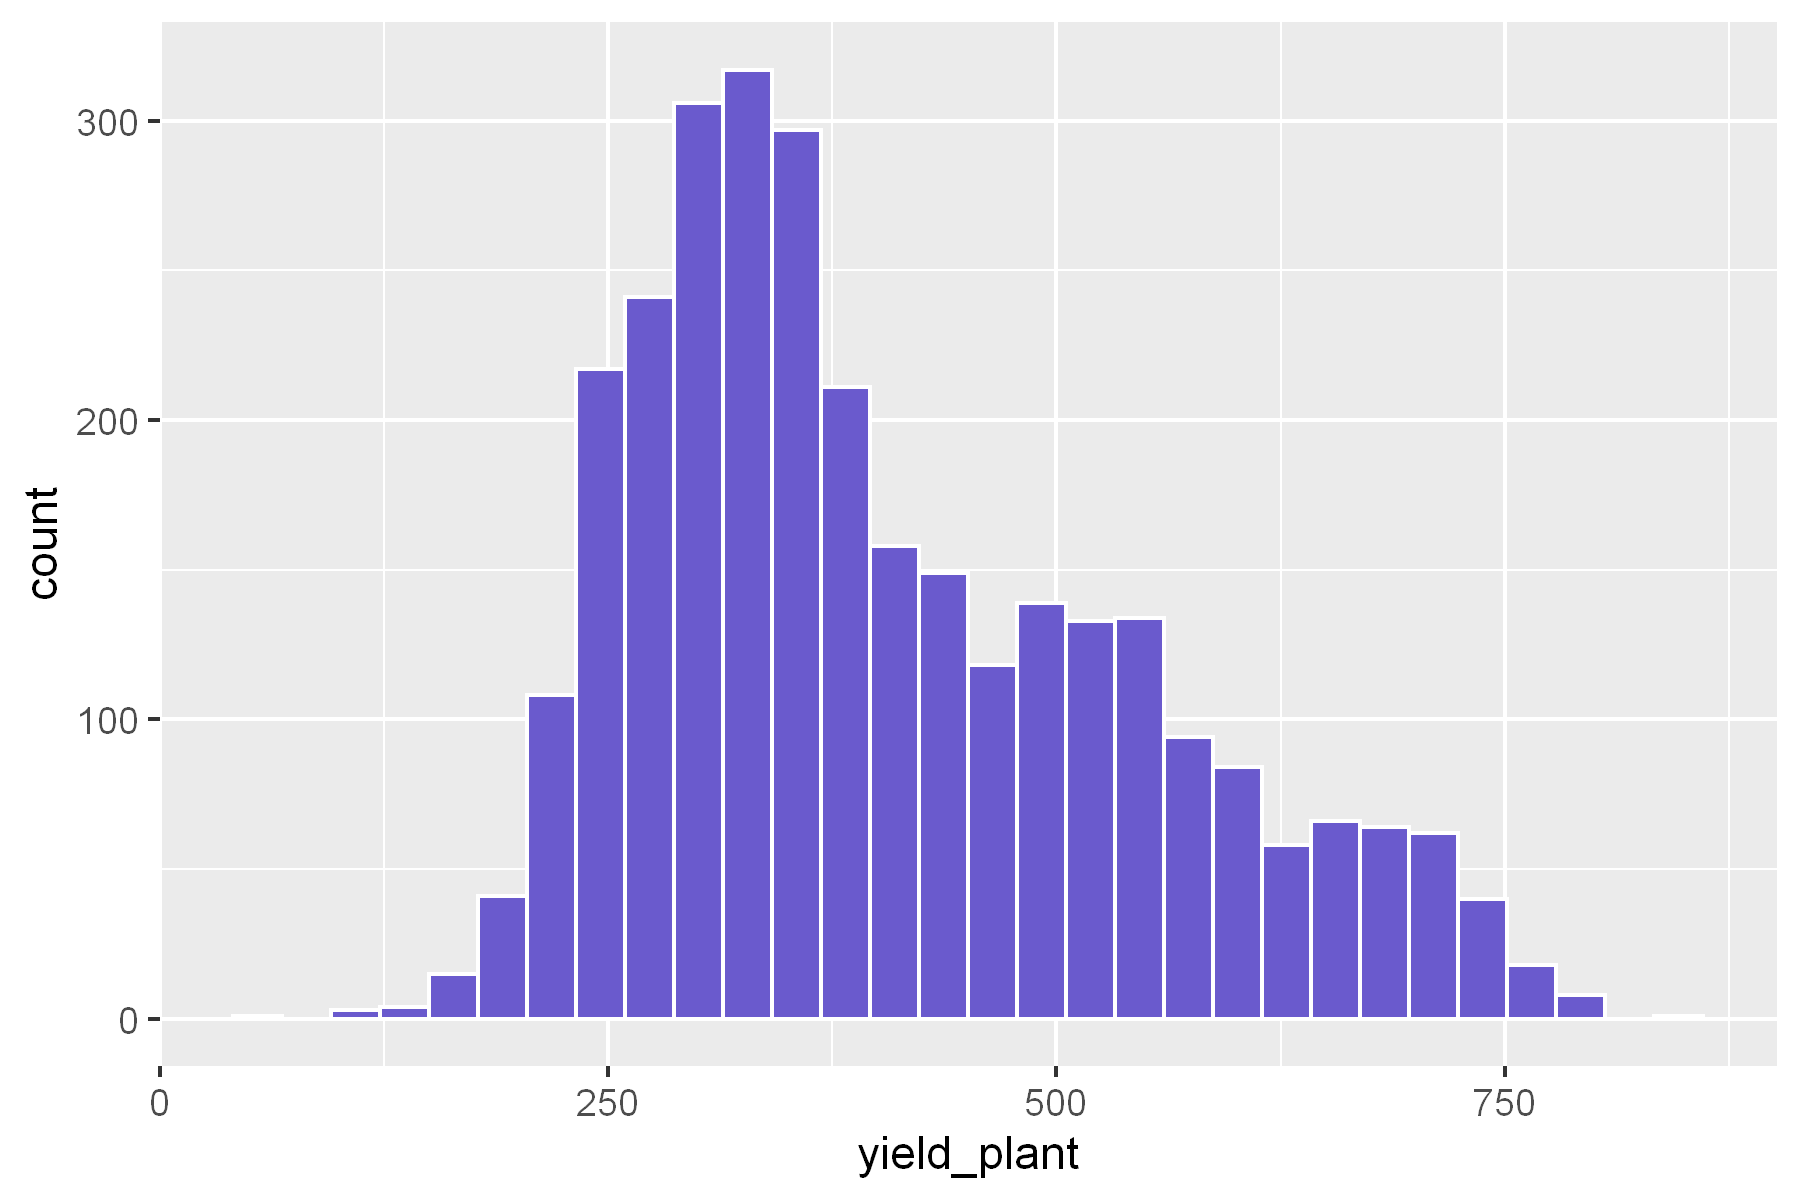

In [19]:
options(repr.plot.height = 4, repr.plot.width = 6)

ggplot(df_rice_1, aes(x = yield_plant)) + 
  geom_histogram(fill = "slateblue", color = "white")

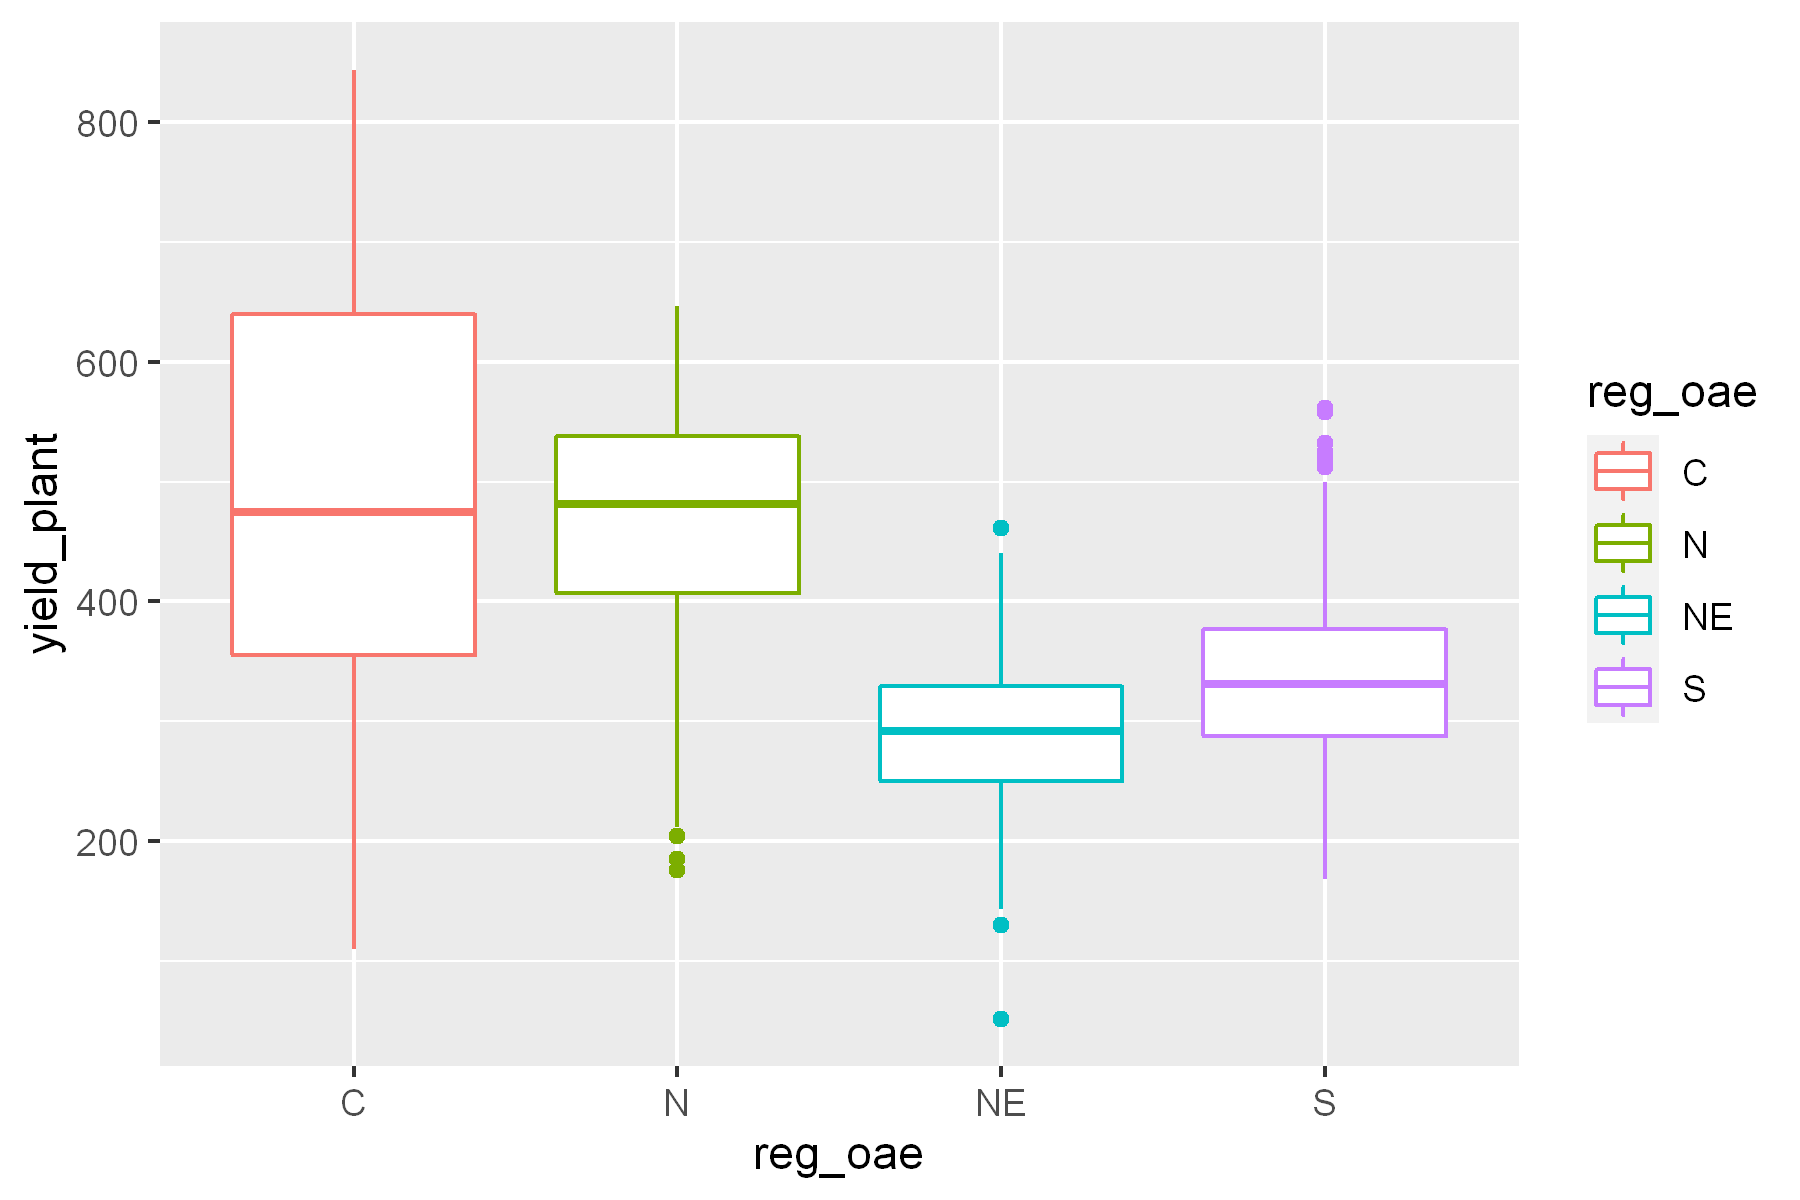

In [20]:
options(repr.plot.height = 4, repr.plot.width = 6)

ggplot(df_rice_1, aes(x = reg_oae, y = yield_plant, color = reg_oae)) + 
  geom_boxplot()

- Correlation (Scatter, Heatmap)

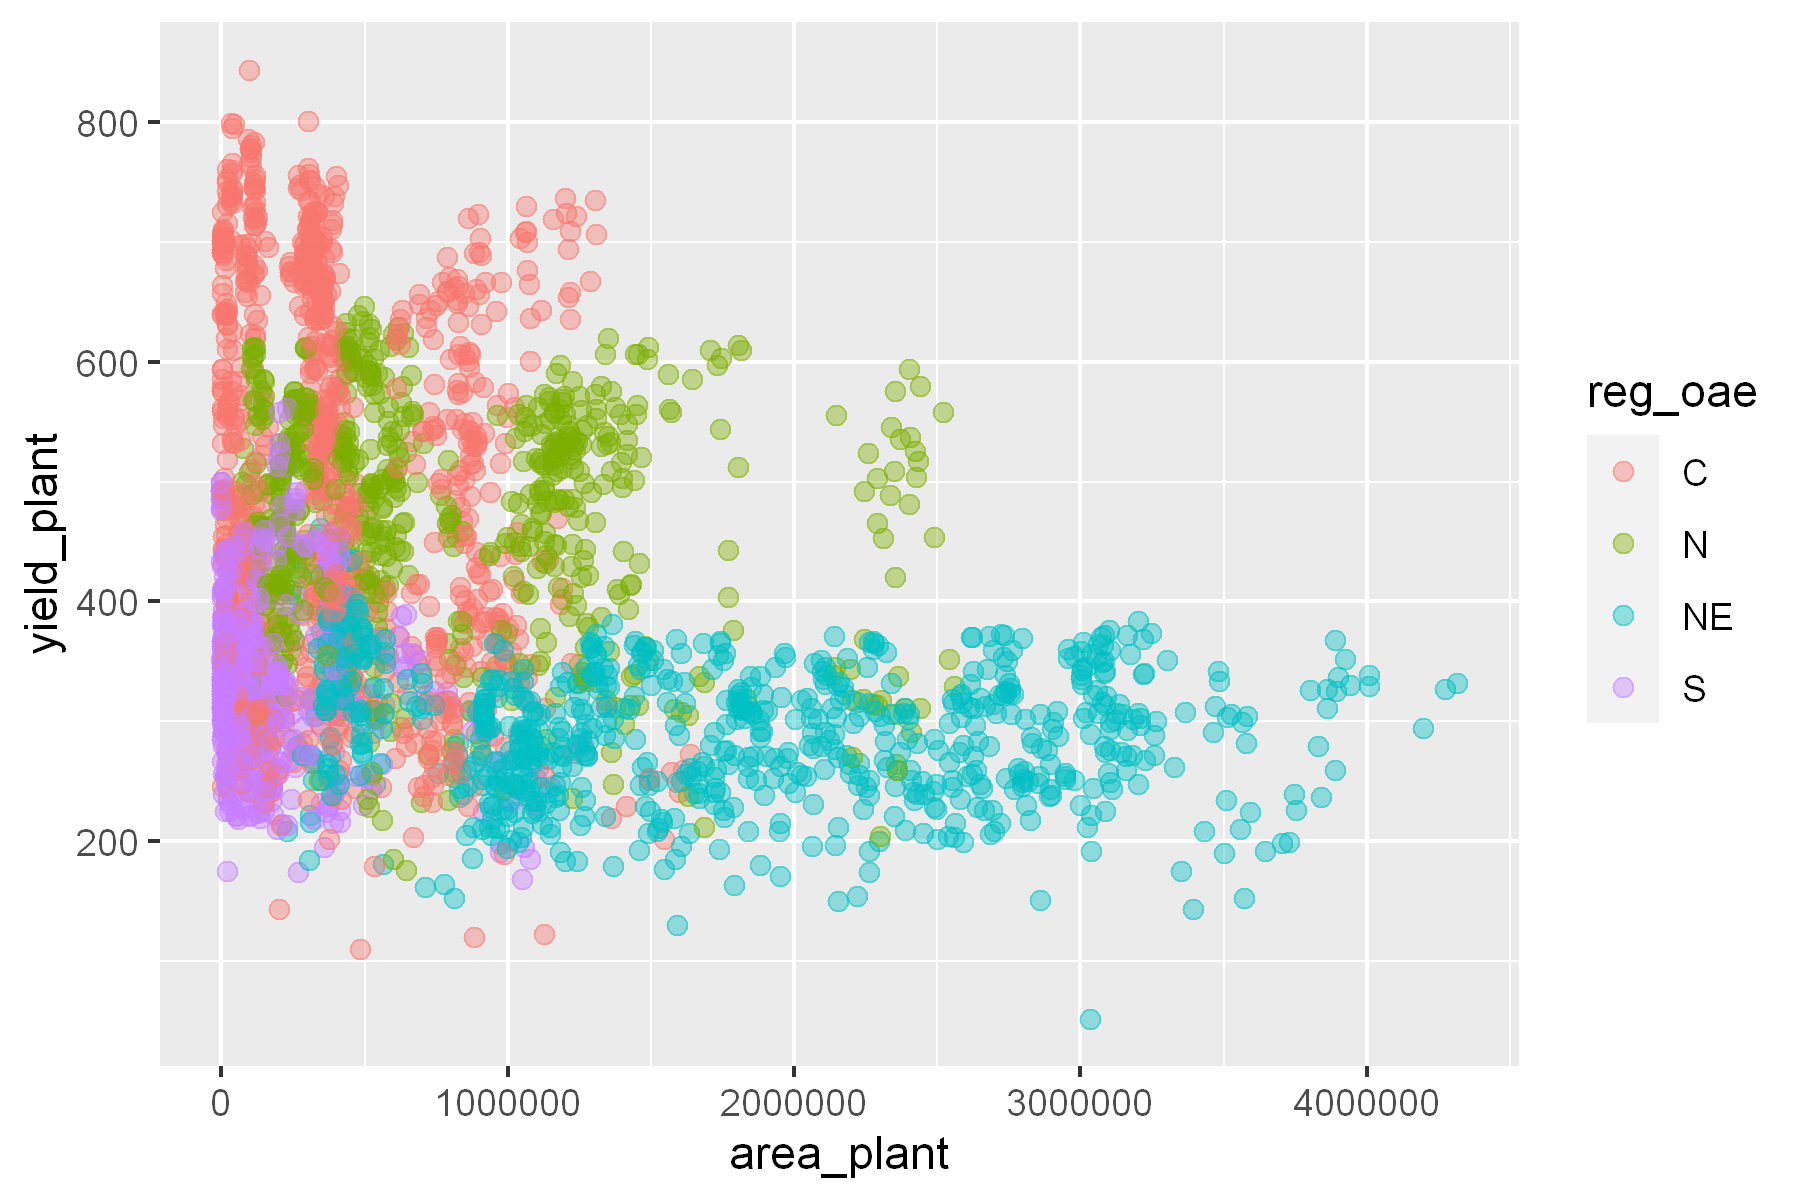

In [25]:
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot(df_rice_1, aes(x = area_plant, y = yield_plant, color = reg_oae)) + 
  geom_point(size = 2, alpha = 0.4)

- Ranking (Bar)

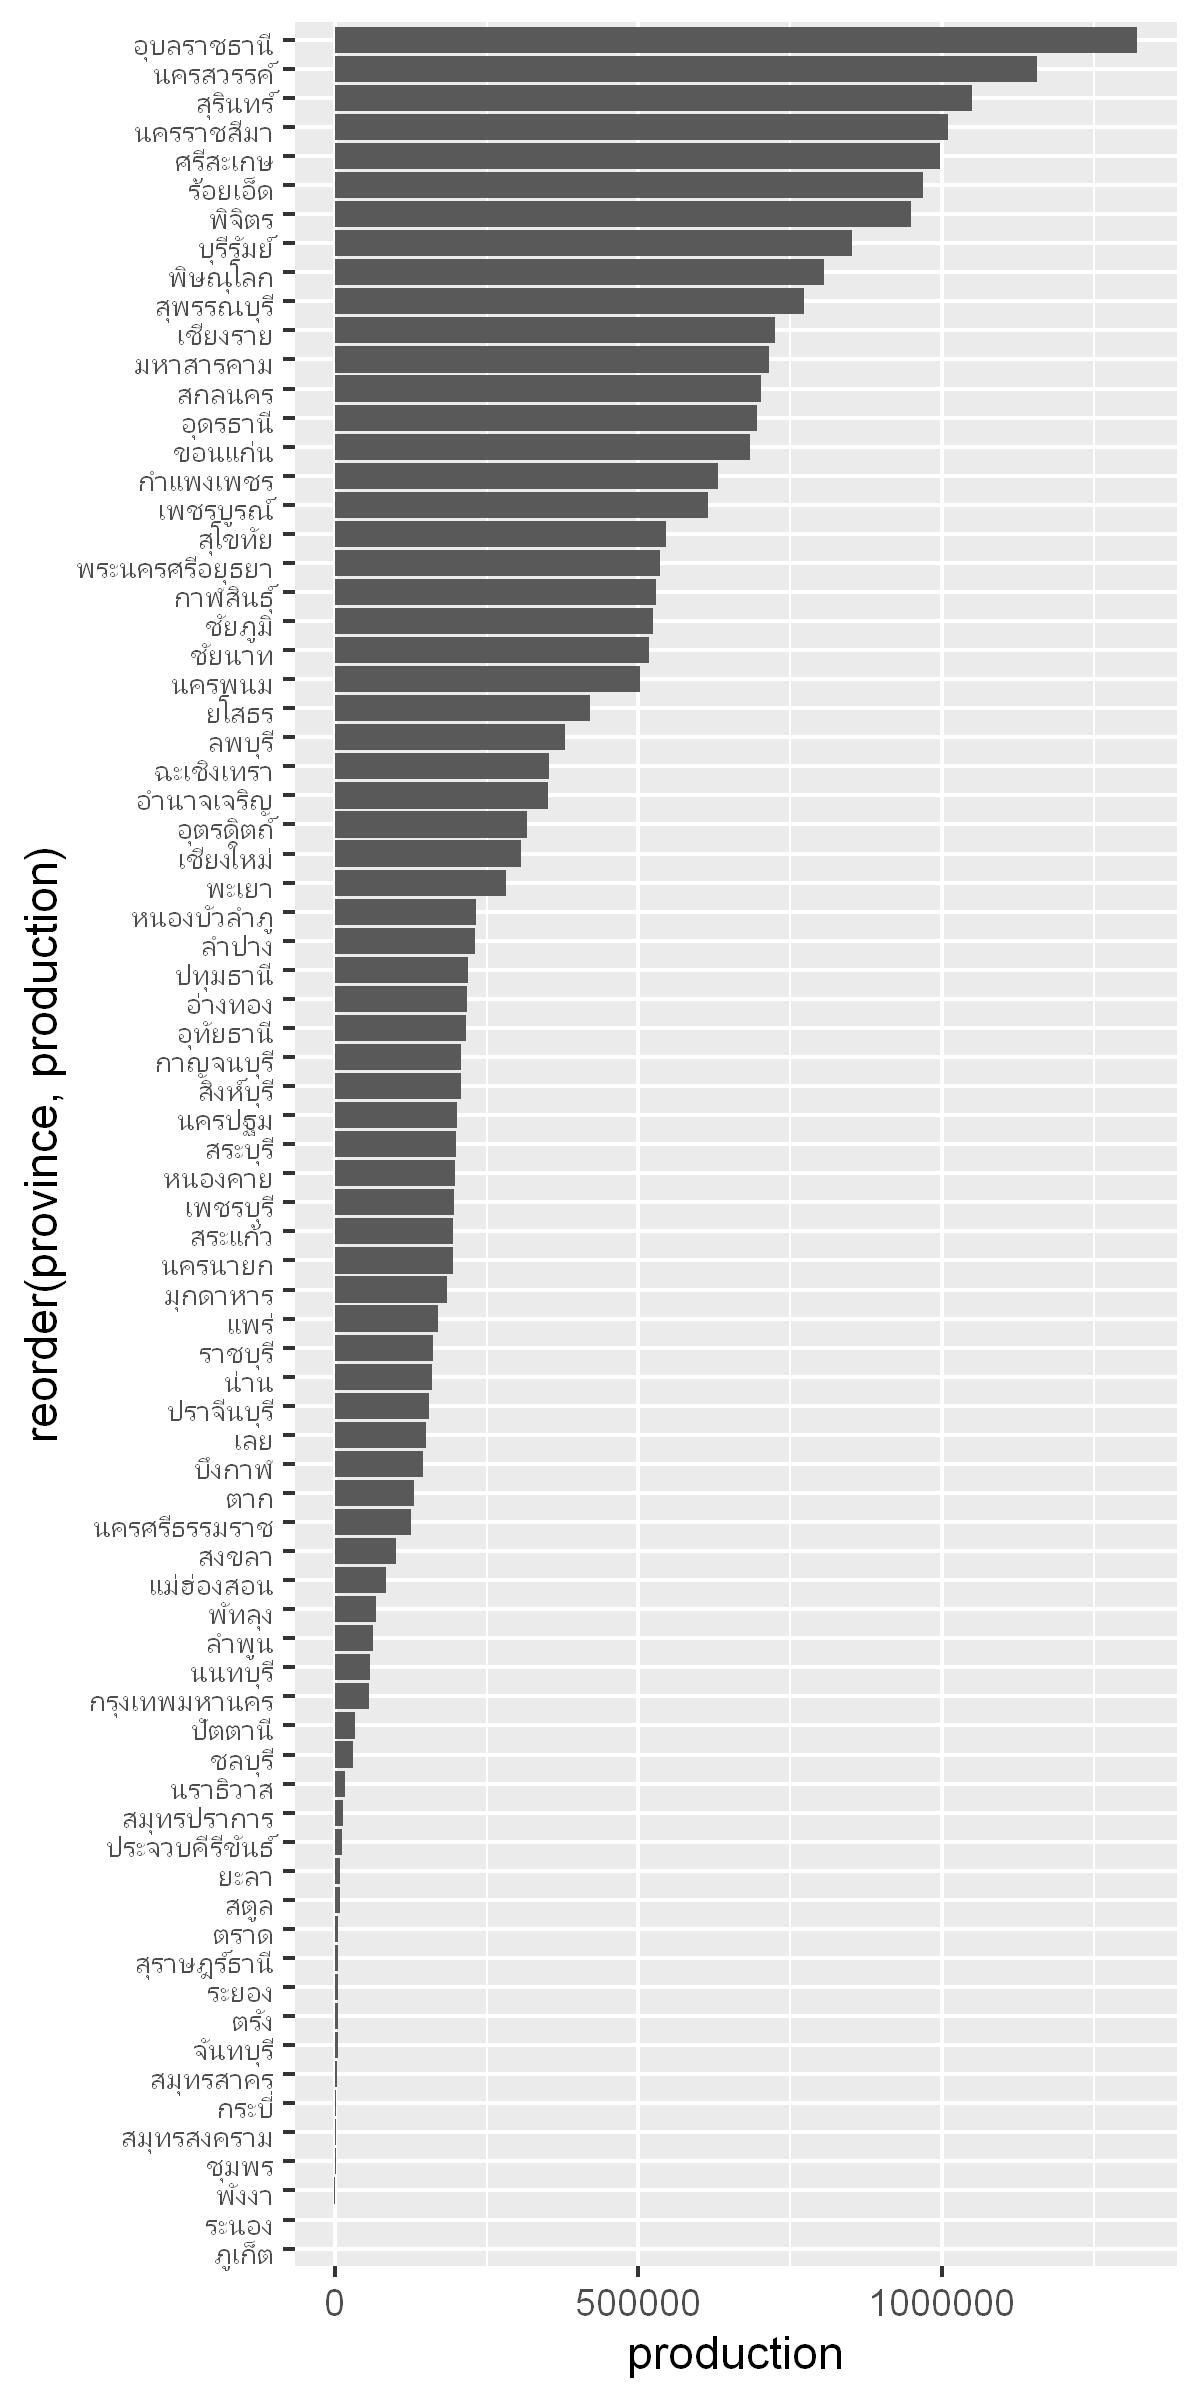

In [26]:
options(repr.plot.height = 8, repr.plot.width = 4)
ggplot(df_rice_1 %>% filter(year_crop == "2563/64"), 
       aes(x = production, y = reorder(province, production)))+
  geom_bar(stat = "identity")

- Part of a whole (Treemap)

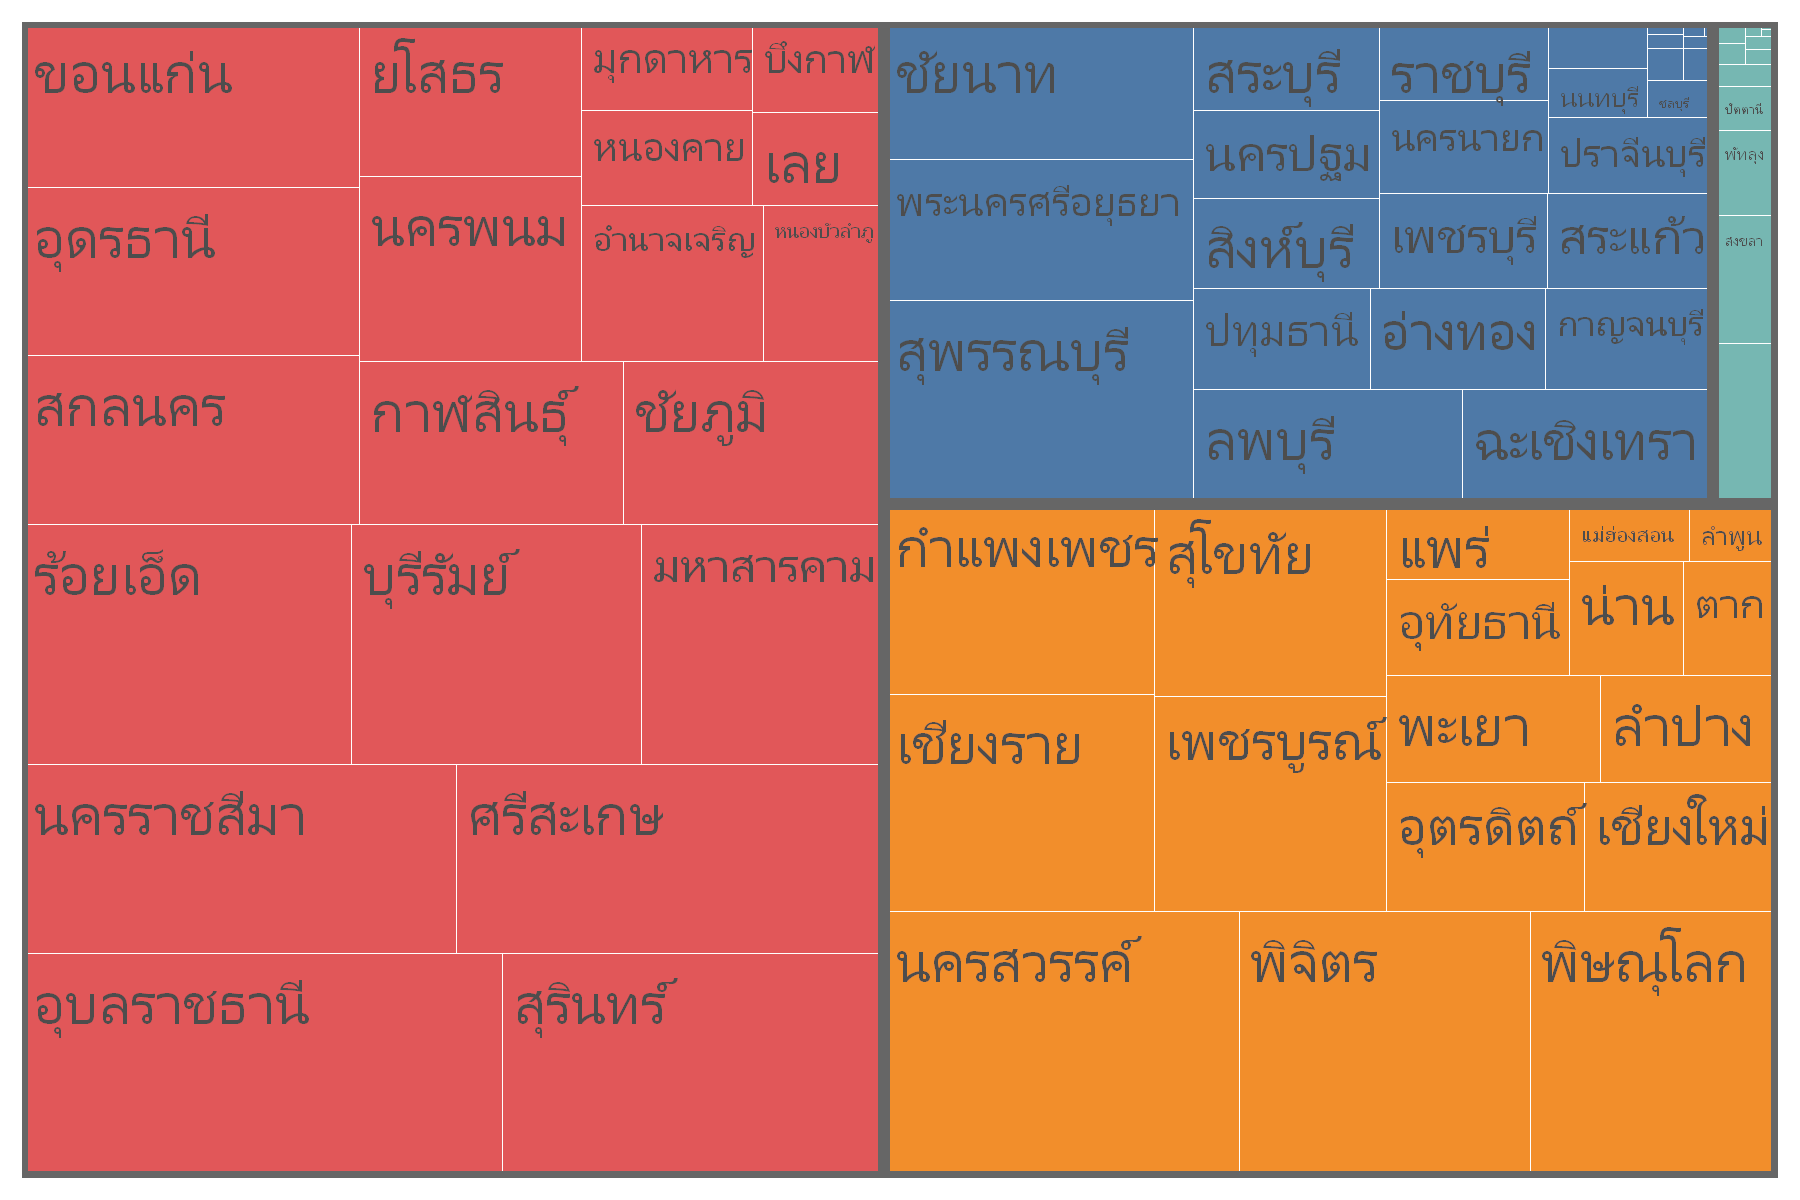

In [29]:
library(treemapify)
library(ggthemes)
options(repr.plot.height = 4, repr.plot.width = 6)

ggplot(df_rice_1 %>% filter(year_crop == "2563/64"), 
       aes(area = production,
           fill = reg_oae, 
           subgroup = reg_oae,
           label = province
          )) +
  geom_treemap(color = "white") +
  geom_treemap_subgroup_border(color = "grey40") +
  geom_treemap_text(colour = "grey30", place = "topleft", reflow = T) +
  theme(legend.position = "none") +
  scale_fill_tableau()

- Evolution (Time Series)

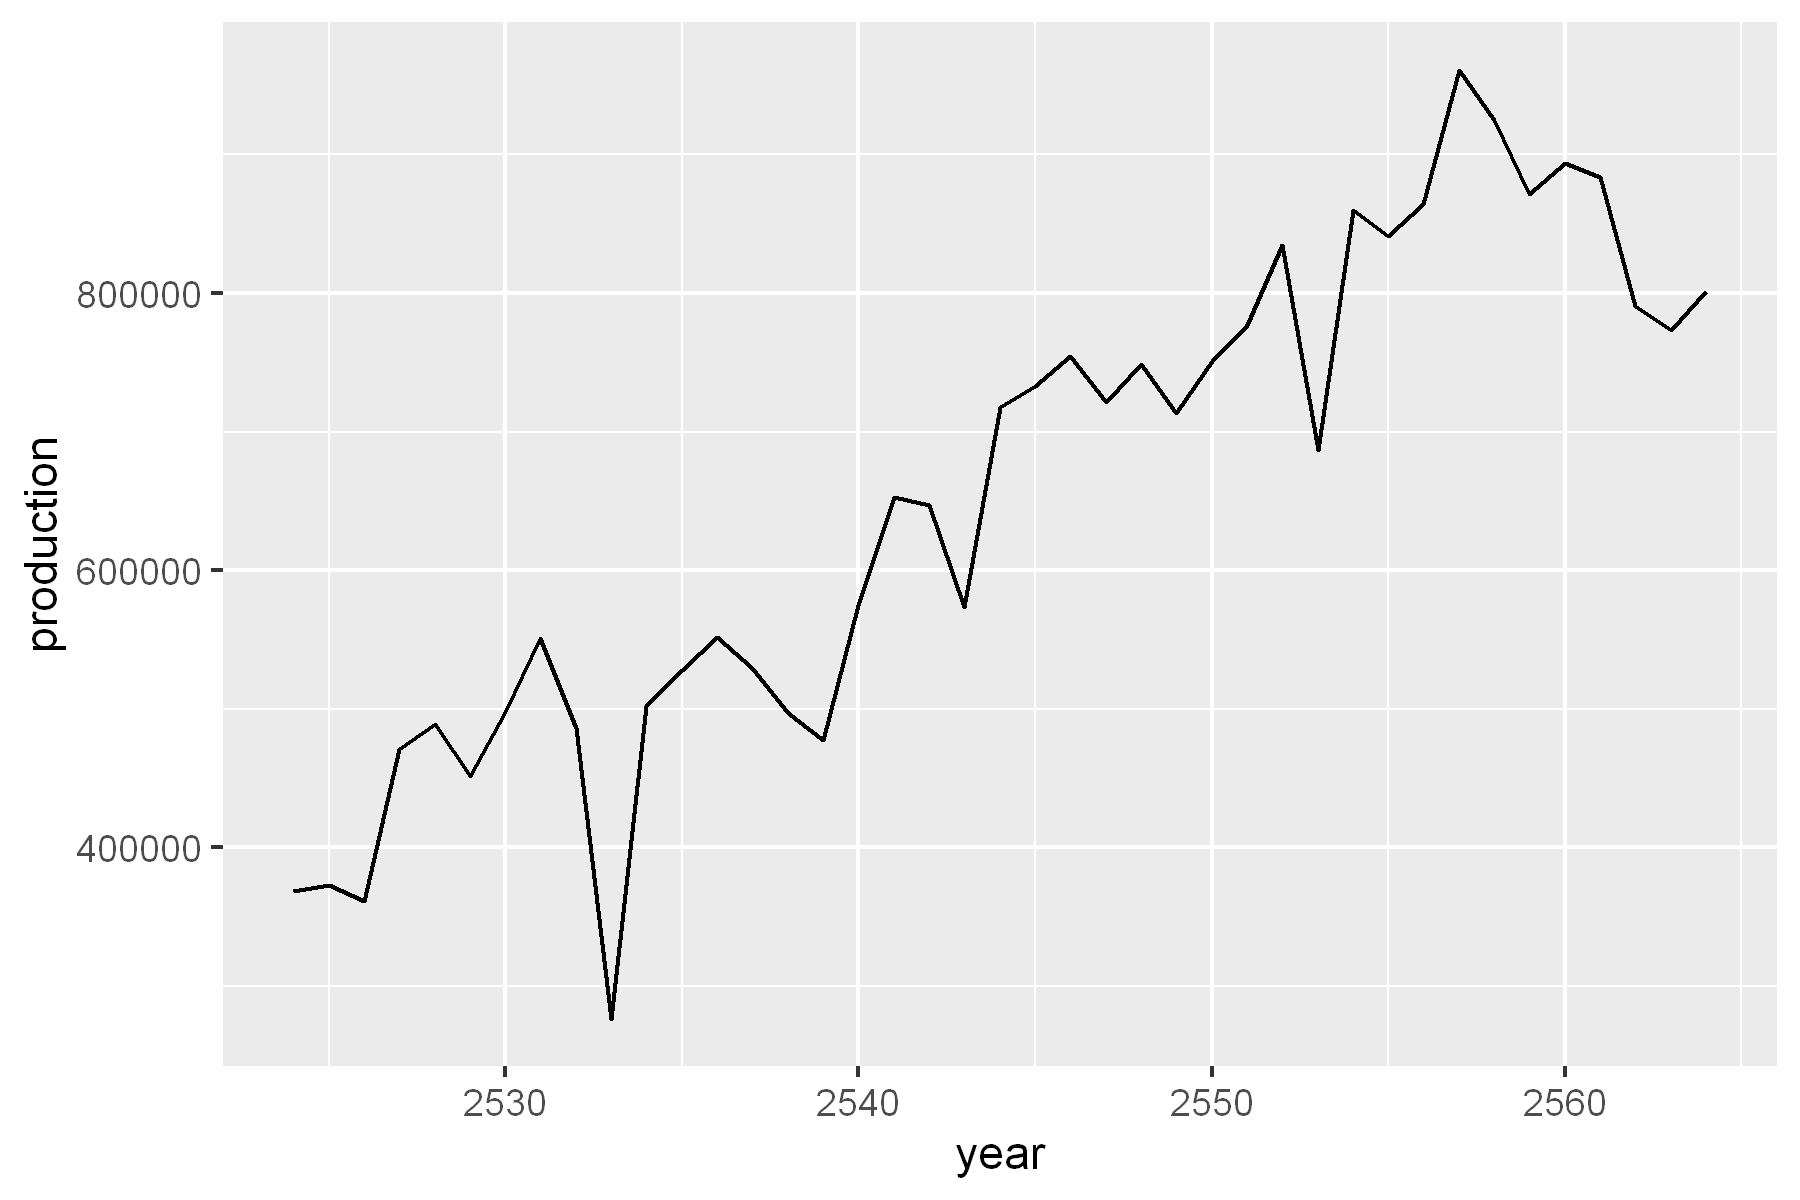

In [30]:
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot(df_rice_1 %>% 
         filter(province == "สุพรรณบุรี") %>% 
         mutate(year = substr(year_crop, 1, 4) %>% as.integer()), 
       aes(x = year, y = production))+
  geom_line()

- Flow

In [35]:
library(ggalluvial)
ref_province <- df_rice_1 %>% 
  filter(province_code >= "TH10") %>%
  count(province, reg_oae, reg_oae, reg_osrt) %>%
  mutate(freq = 1)
ref_province

province      reg_oae reg_osrt n   freq
1   กระบี่        S       S        41  1   
2   กรุงเทพมหานคร C       C        41  1   
3   กาญจนบุรี     C       W        41  1   
4   กำแพงเพชร     N       C        41  1   
5   กาฬสินธุ์     NE      NE       41  1   
... ...           ...     ...      ... ... 
73  อุทัยธานี     N       C        41  1   
74  อำนาจเจริญ    NE      NE       28  1   
75  อุบลราชธานี   NE      NE       41  1   
76  บึงกาฬ        NE      NE       11  1   
77  บุรีรัมย์     NE      NE       41  1

In [36]:
reg_osrt_lvl <- c("N", "NE", "W", "C", "E", "S")
reg_oae_lvl  <- c("N", "NE", "C", "S")

In [37]:
ref_compare <- ref_province %>% mutate(
  reg_oae = factor(reg_oae, levels = reg_oae_lvl),
  reg_osrt = factor(reg_osrt, levels = reg_osrt_lvl)
)

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."


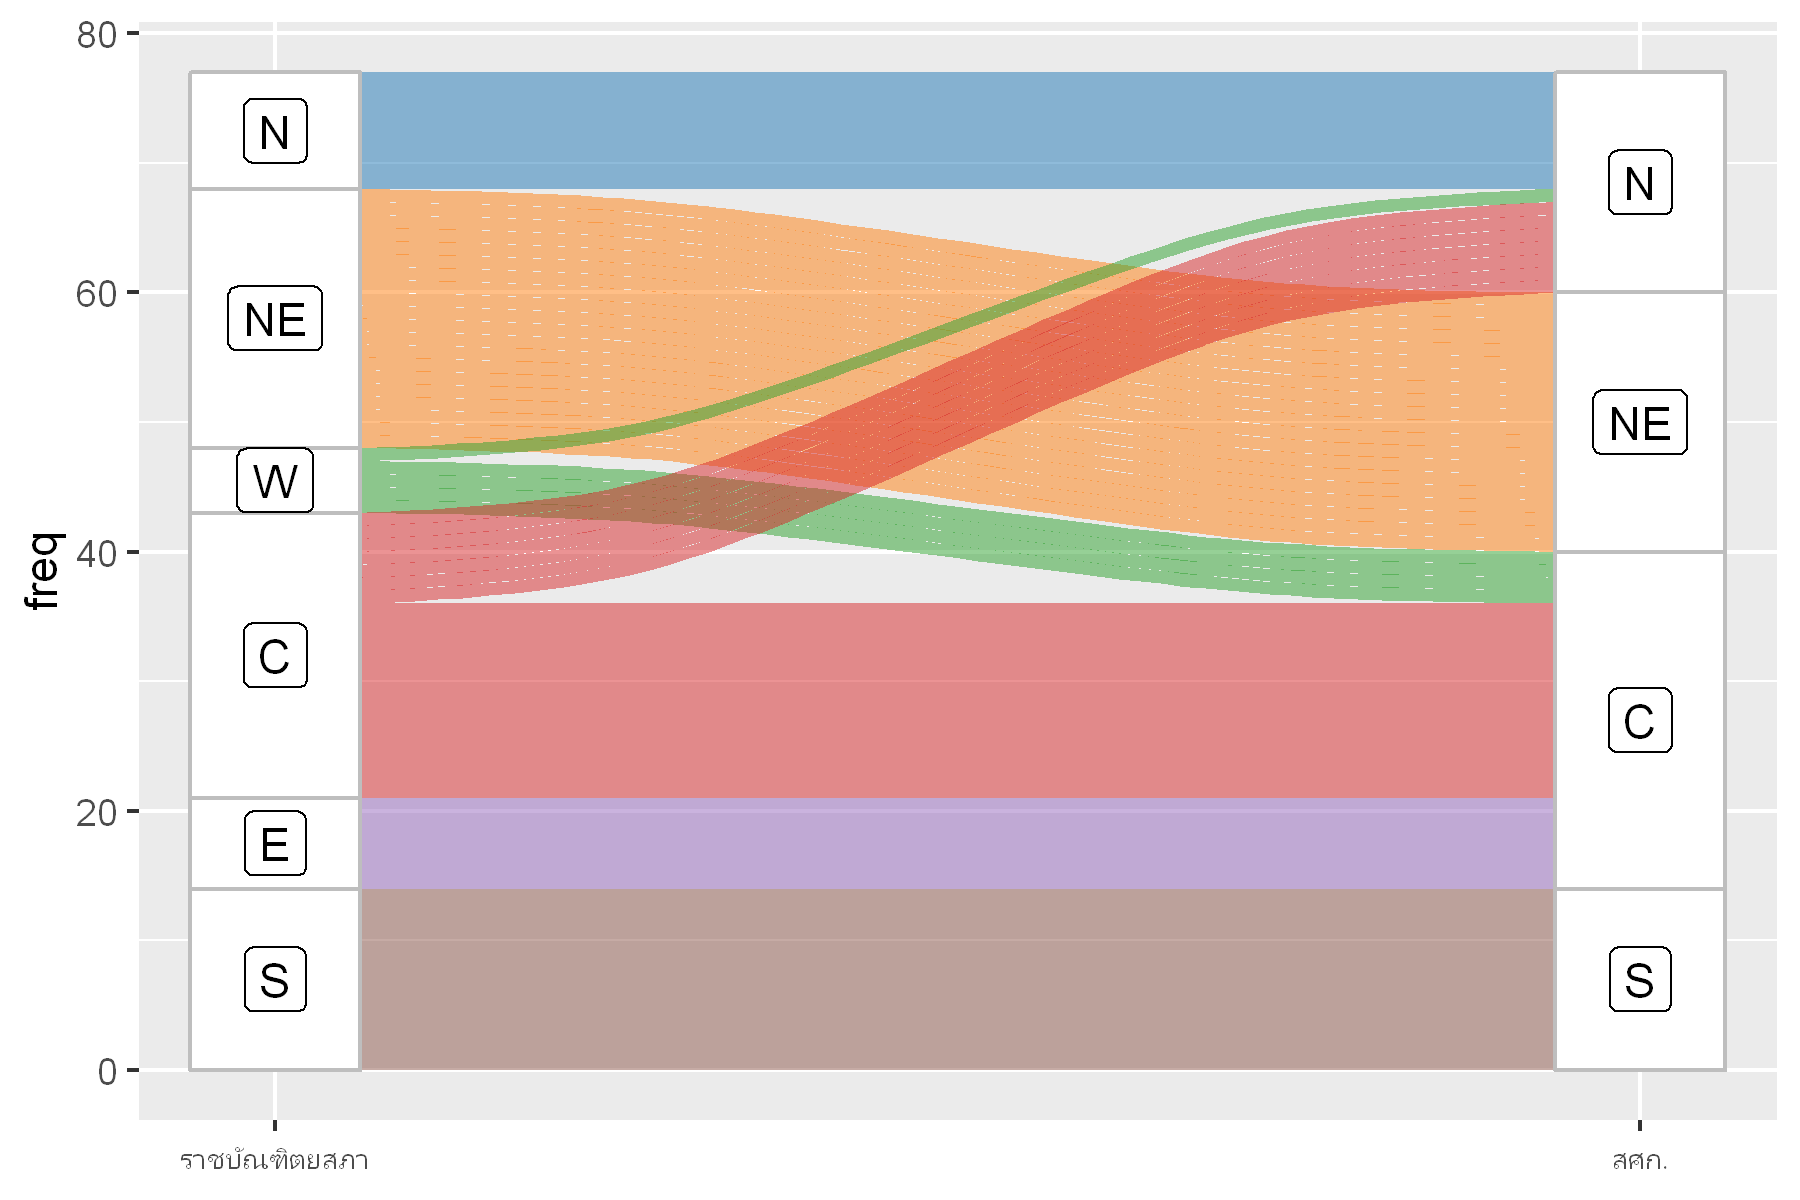

In [41]:
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot(ref_compare,
       aes(y = freq, axis1 = reg_osrt, axis2 = reg_oae)) +
  geom_alluvium(aes(fill = reg_osrt), width = 1/8) +
  geom_stratum(width = 1/8, color = "grey") + 
  geom_label(stat = "stratum", aes(label = after_stat(stratum))) +
  scale_fill_d3() +
  scale_x_discrete(limits = c("ราชบัณฑิตยสภา", "สศก."), expand = c(.05, .05)) + 
  theme(legend.position = "none")

## Dynamics
เป็นการแสดงกราฟที่ผู้ใช้สามารถ interact ได้ เช่น zoom, mouse hover, mouse click เป็นต้น ส่วนใหญ่จะใช้ javascript ในการประมวลผลและแสดงผลบนเวบ สำหรับมี library หลายตัว เช่น
- [plotly](https://plotly.com/r/)
- [echart](https://echarts4r.john-coene.com)
- [highcharters](https://jkunst.com/highcharter/)
- [d3](https://rstudio.github.io/r2d3/)
- และอื่นๆ อีกมากมาย

In [42]:
g <- ggplot(df_rice_1, aes(x = reg_oae, y = yield_plant)) + 
  geom_boxplot()

plotly::ggplotly(g)

HTML widgets cannot be represented in plain text (need html)

# Map

มีหลาย file format ที่นิยม เช่น
- geojson
- shapefile
- geotif

website ที่แจกข้อมูลแผนที่
- https://www.naturalearthdata.com/downloads/
- http://www.diva-gis.org/gdata
- https://data.humdata.org/dataset/thailand-administrative-boundaries
- https://github.com/16EAGLE/getSpatialData

## Static

In [50]:
df_map <- df %>%
  filter(subcommod == "ข้าวนาปี", year_crop == "2563/64")

In [52]:
df_map <- tha1 %>% left_join(df_map, by = c("adm1_pcode" = "province_code"))

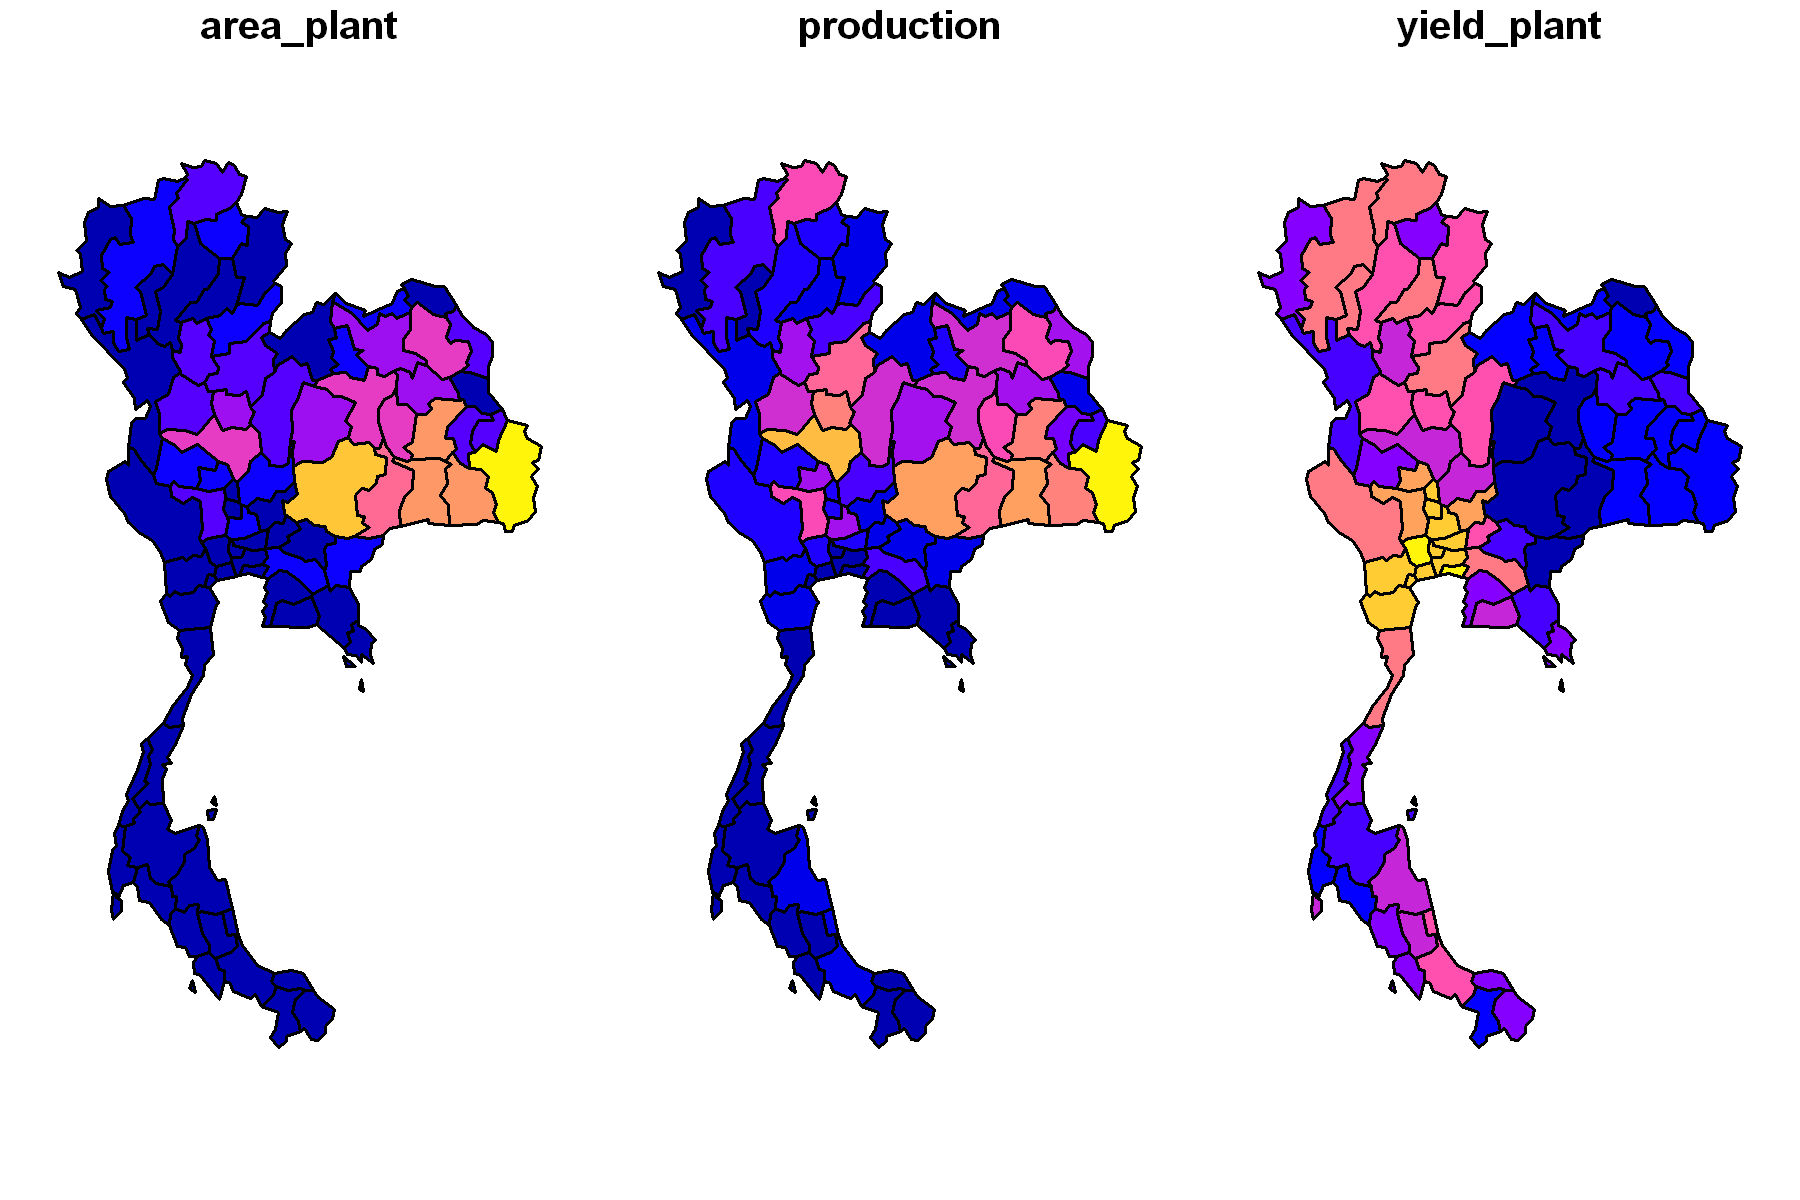

In [53]:
plot(df_map[c('area_plant', 'production', 'yield_plant')])

## Dynamics

In [57]:
leaflet(df_map) %>%
  addTiles() %>%
  addPolygons()

HTML widgets cannot be represented in plain text (need html)

In [59]:
## advance
pal <- colorBin("magma", domain = df_map$production, reverse = TRUE)

labels <- glue::glue(
  "<strong>{df_map$adm1_th}</strong><br/>
  ปีเพาะปลูก: {df_map$year_crop}<br/>
  ผลผลิต: {df_map$production} ตัน <br/>"
) %>% lapply(htmltools::HTML)

leaflet(df_map) %>%
  addProviderTiles(providers$CartoDB.Voyager) %>%
  addPolygons(
    fillColor = ~pal(production),
    weight = 1,
    opacity = 1,
    color = "white",
    dashArray = "3",
    fillOpacity = 0.7,
    highlight = highlightOptions(
      weight = 5,
      color = "#666",
      dashArray = "",
      fillOpacity = 0.7,
      bringToFront = TRUE
    ),
    label = labels
  ) %>%
  addLegend(
    pal = pal, values = ~production, opacity = 0.7, 
    title = "ผลผลิต (ตัน)", position = "bottomright"
  )

HTML widgets cannot be represented in plain text (need html)

# Put it all together
แรงบันดาลใจมาจาก https://www.cedricscherer.com/2019/05/17/the-evolution-of-a-ggplot-ep.-1/

In [60]:
df

commod subcommod        season variety       year_crop year
1     ข้าว   ข้าวนาปี         1      ข้าวรวม       2524/25   2524
2     ข้าว   ข้าวนาปี         1      ข้าวรวม       2524/25   2524
3     ข้าว   ข้าวนาปี         1      ข้าวรวม       2524/25   2524
4     ข้าว   ข้าวนาปี         1      ข้าวรวม       2524/25   2524
5     ข้าว   ข้าวนาปี         1      ข้าวรวม       2524/25   2524
...   ...    ...              ...    ...           ...       ... 
18681 ข้าว   ข้าวเหนียวนาปรัง 2      ข้าวเหนียวรวม 2563/64   2564
18682 ข้าว   ข้าวเหนียวนาปรัง 2      ข้าวเหนียวรวม 2563/64   2564
18683 ข้าว   ข้าวเหนียวนาปรัง 2      ข้าวเหนียวรวม 2563/64   2564
18684 ข้าว   ข้าวเหนียวนาปรัง 2      ข้าวเหนียวรวม 2563/64   2564
18685 ข้าว   ข้าวเหนียวนาปรัง 2      ข้าวเหนียวรวม 2563/64   2564
      province              province_code reg_oae reg_nesdb reg_osrt status 
1     ประเทศไทย             TH00          NA      NA        NA       สถิติ  
2     ภาคเหนือ              TH01          NA      NA        NA       สถิติ  
3     ภาคตะวันออกเฉียงเหนือ TH02          NA      NA        NA       สถิติ  
4     ภาคกลาง               TH03          NA      NA        NA       สถิติ  
5     ภาคใต้                TH06          NA      NA        NA       สถิติ  
...   ...                   ...           ...     ...       ...      ...    
18681 อุตรดิตถ์             TH53          N       N         N        พยากรณ์
18682 อำนาจเจริญ            TH37          NE      NE        NE       พยากรณ์
18683 อุบลราชธานี           TH34          NE      NE        NE       พยากรณ์
18684 บึงกาฬ                TH38          NE      NE        NE       พยากรณ์
18685 บุรีรัมย์             TH31          NE      NE        NE       พยากรณ์
      update_date area_plant area_harvest production yield_plant yield_harvest
1     2556-11-21  56392231   53383281     15757745   279.4311    295.1813     
2     2556-11-21  12655814   12422132      5258621   415.5103    423.3268     
3     2556-11-21  28000661   26103169      5389709   192.4851    206.4772     
4     2556-11-21  11660934   11415444      4010097   343.8916    351.2870     
5     2556-11-21   4074822    3442536      1099318   269.7831    319.3338     
...   ...         ...        ...          ...        ...         ...          
18681 2556-06-25  12631      12568         7882      624.0203    627.1483     
18682 2556-06-25    510        510          237      464.7059    464.7059     
18683 2556-06-25  40156      40036        19877      494.9945    496.4782     
18684 2556-06-25  13565      13416         6837      504.0177    509.6154     
18685 2556-06-25   1120       1075          491      438.3929    456.7442

In [61]:
region_label = c(
  "N" = "เหนือ",
  "NE" = "ตะวันออก\nเฉียงเหนือ",
  "C" = "กลาง",
  "S" = "ใต้"
)
region_label

N                     NE                      C 
               "เหนือ" "ตะวันออก\nเฉียงเหนือ"                 "กลาง" 
                     S 
                 "ใต้"

In [92]:
df_rice_major <- df %>%
  filter(subcommod == "ข้าวนาปี", year_crop == "2564/65", !is.na(reg_oae)) %>%
  mutate(region = as_factor(region_label[reg_oae]))

df_rice_major

commod subcommod season variety year_crop year province  province_code
1   ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 เชียงราย  TH57         
2   ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 พะเยา     TH56         
3   ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 ลำปาง     TH52         
4   ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 ลำพูน     TH51         
5   ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 เชียงใหม่ TH50         
... ...    ...       ...    ...     ...       ...  ...       ...          
73  ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 สงขลา     TH90         
74  ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 สตูล      TH91         
75  ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 ปัตตานี   TH94         
76  ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 ยะลา      TH95         
77  ข้าว   ข้าวนาปี  1      ข้าวรวม 2564/65   2564 นราธิวาส  TH96         
    reg_oae reg_nesdb reg_osrt status  update_date area_plant area_harvest
1   N       N         N        พยากรณ์ 2564-06-25  1309930    1279807     
2   N       N         N        พยากรณ์ 2564-06-25   638268     628735     
3   N       N         N        พยากรณ์ 2564-06-25   447301     443723     
4   N       N         N        พยากรณ์ 2564-06-25   110133     109371     
5   N       N         N        พยากรณ์ 2564-06-25   528229     523726     
... ...     ...       ...      ...     ...         ...        ...         
73  S       S         S        พยากรณ์ 2564-06-25  196668     182973      
74  S       S         S        พยากรณ์ 2564-06-25   19999      19999      
75  S       S         S        พยากรณ์ 2564-06-25   76887      76887      
76  S       S         S        พยากรณ์ 2564-06-25   24877      24777      
77  S       S         S        พยากรณ์ 2564-06-25   40393      40293      
    production yield_plant yield_harvest region
1   734611     560.8017    574.0014      เหนือ 
2   297646     466.3339    473.4045      เหนือ 
3   234476     524.2018    528.4288      เหนือ 
4    66659     605.2591    609.4760      เหนือ 
5   318664     603.2687    608.4556      เหนือ 
... ...        ...         ...           ...   
73  102074     519.0168    557.8637      ใต้   
74    8864     443.2222    443.2222      ใต้   
75   34753     452.0010    452.0010      ใต้   
76    8657     347.9921    349.3966      ใต้   
77   18015     445.9931    447.1000      ใต้

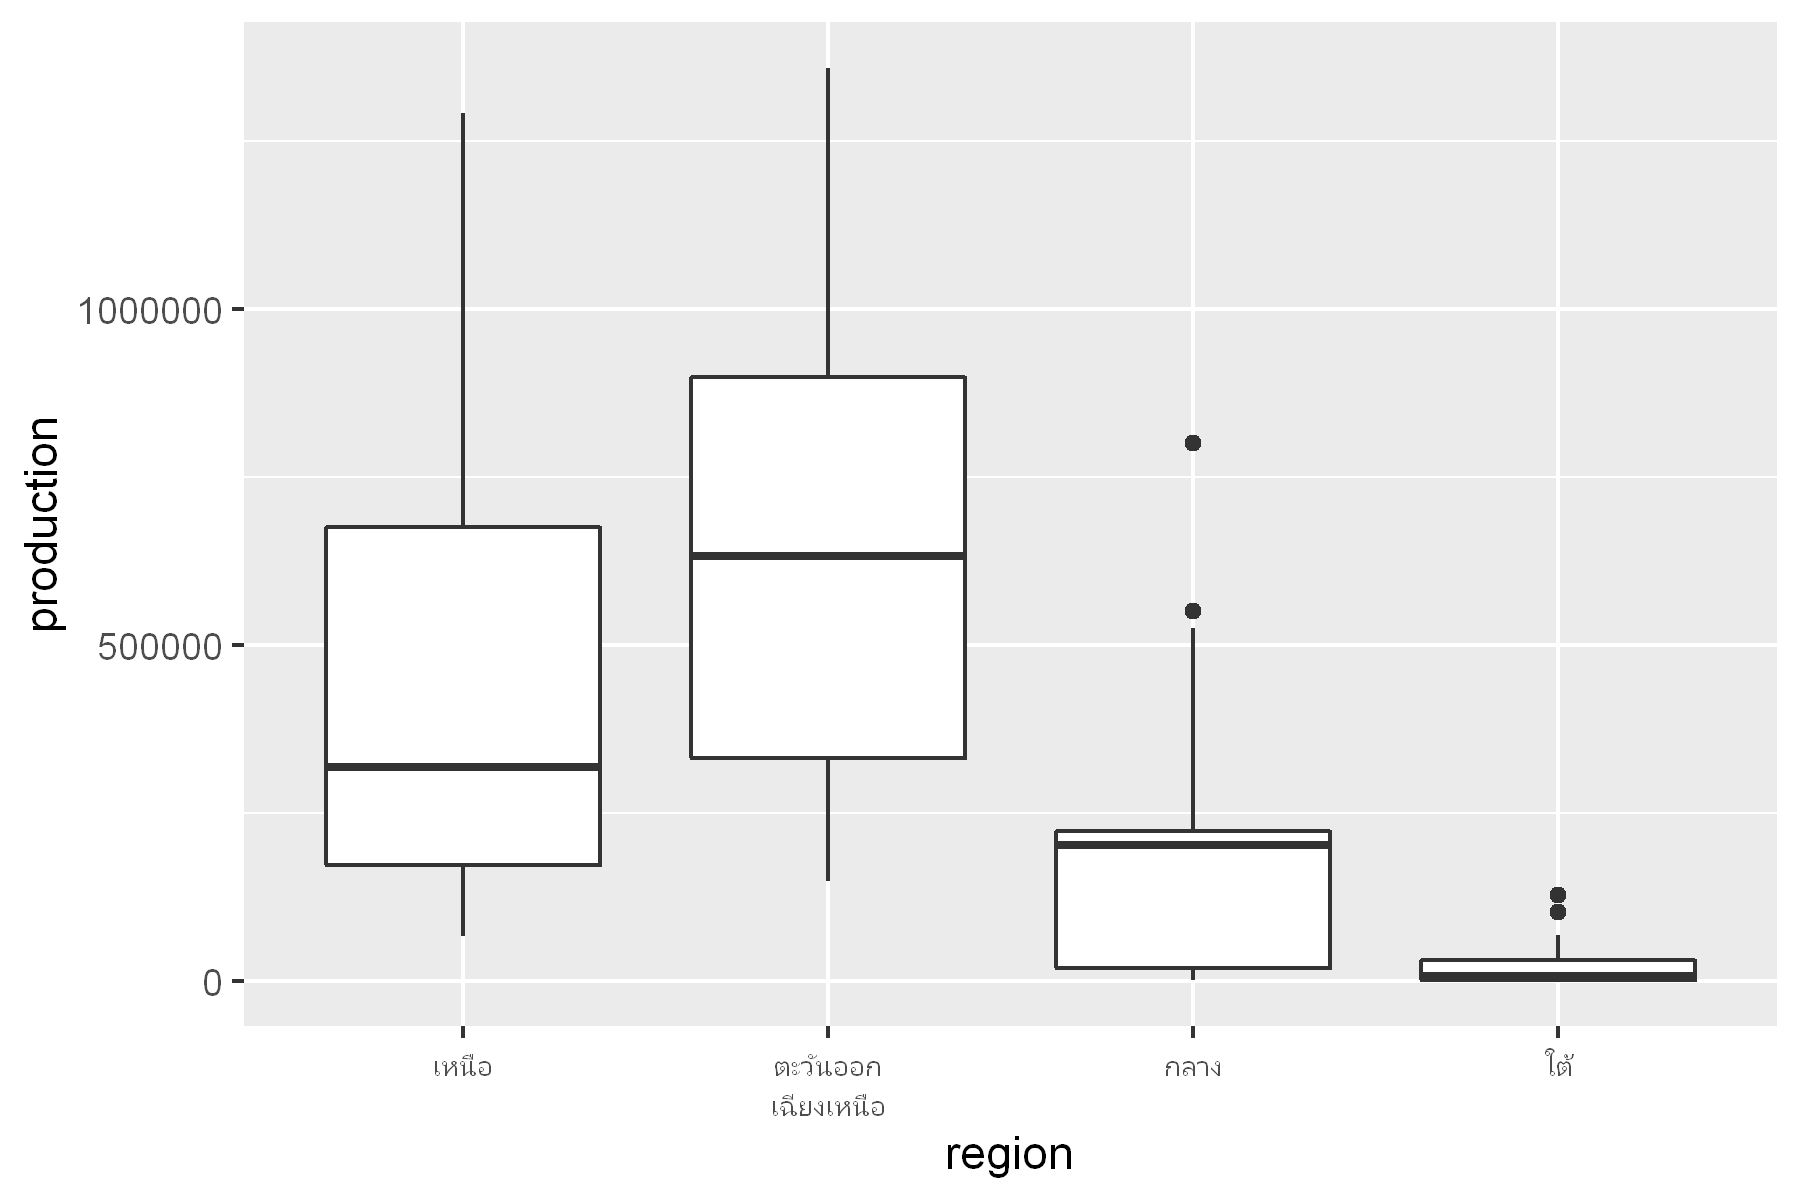

In [93]:
options(repr.plot.height = 4, repr.plot.width = 6)
ggplot(df_rice_major, aes(x = region, y = production)) +
  geom_boxplot()

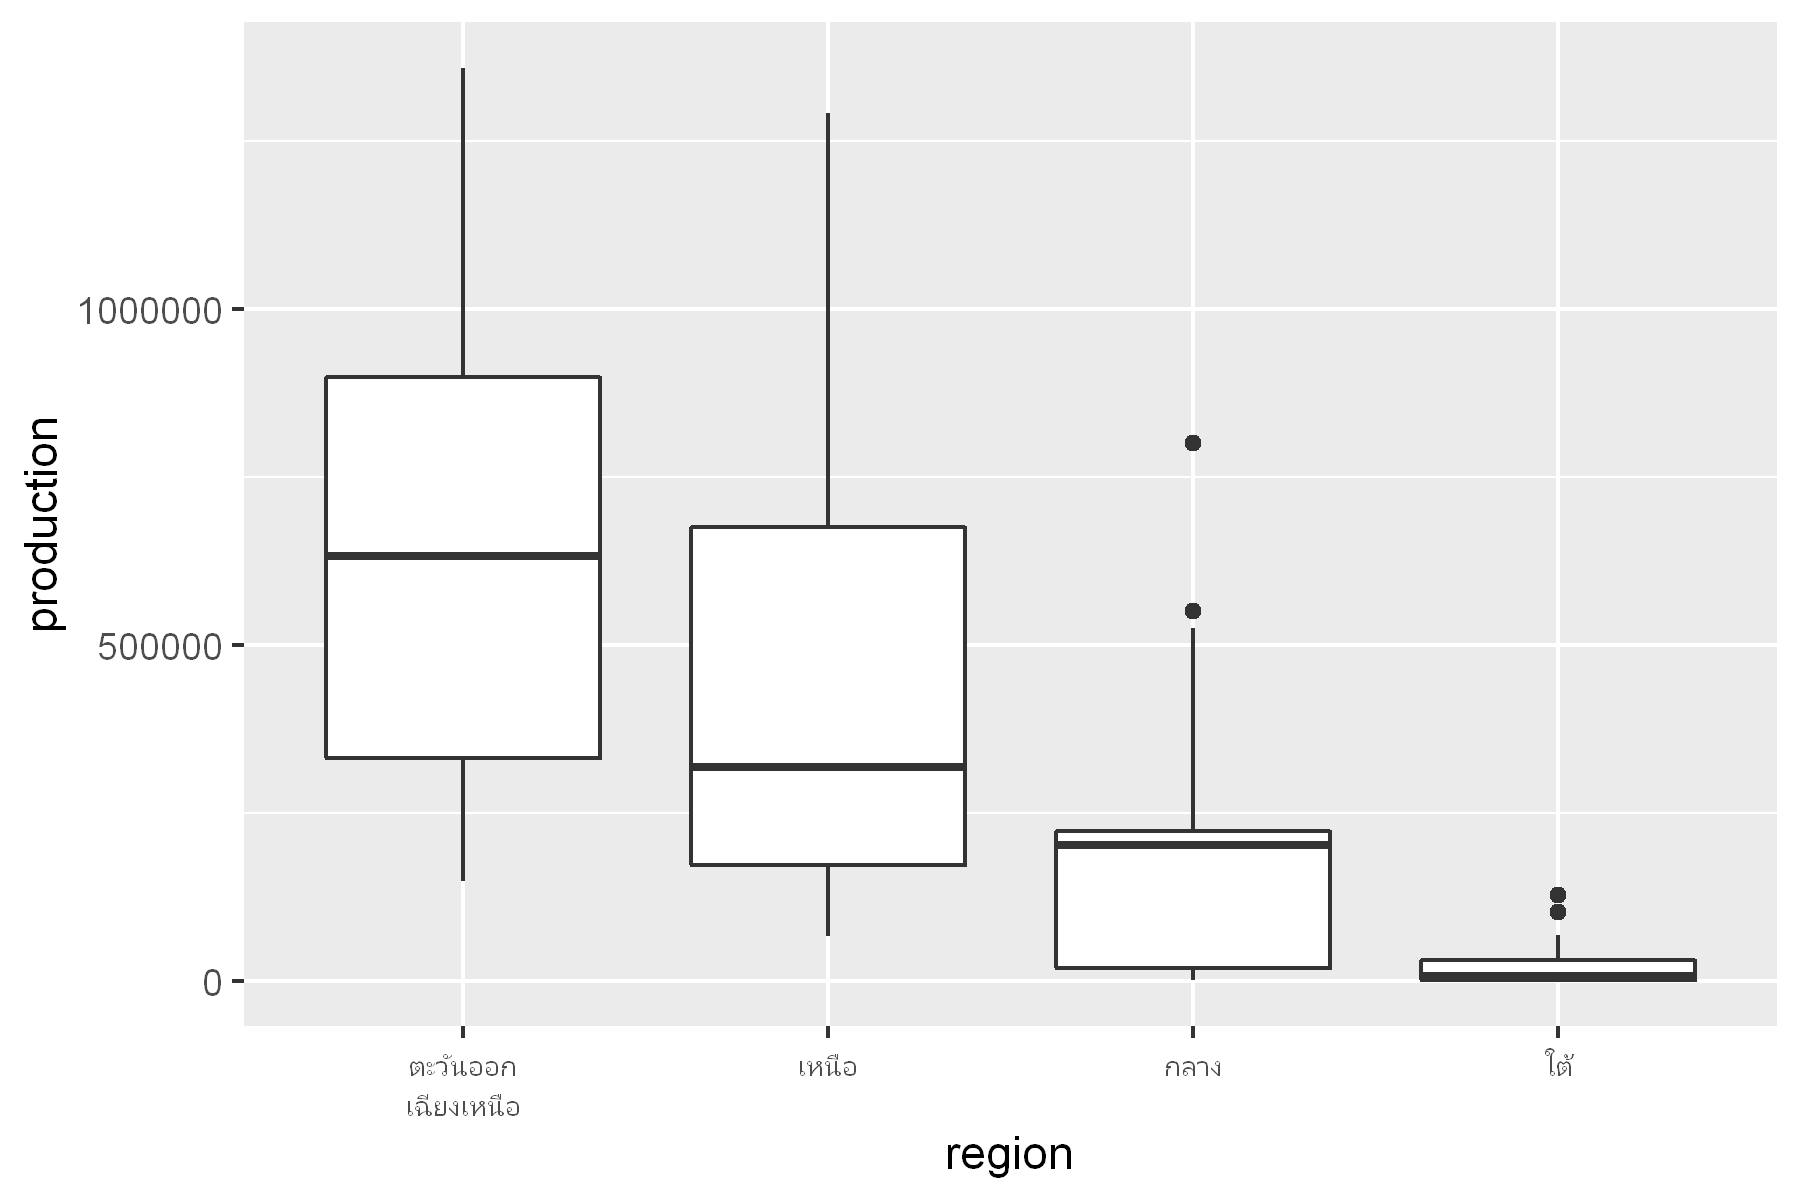

In [94]:
df_sorted <-
  df_rice_major %>%
  mutate(region = fct_reorder(region, -production))

ggplot(df_sorted, aes(x = region, y = production)) +
  geom_boxplot()

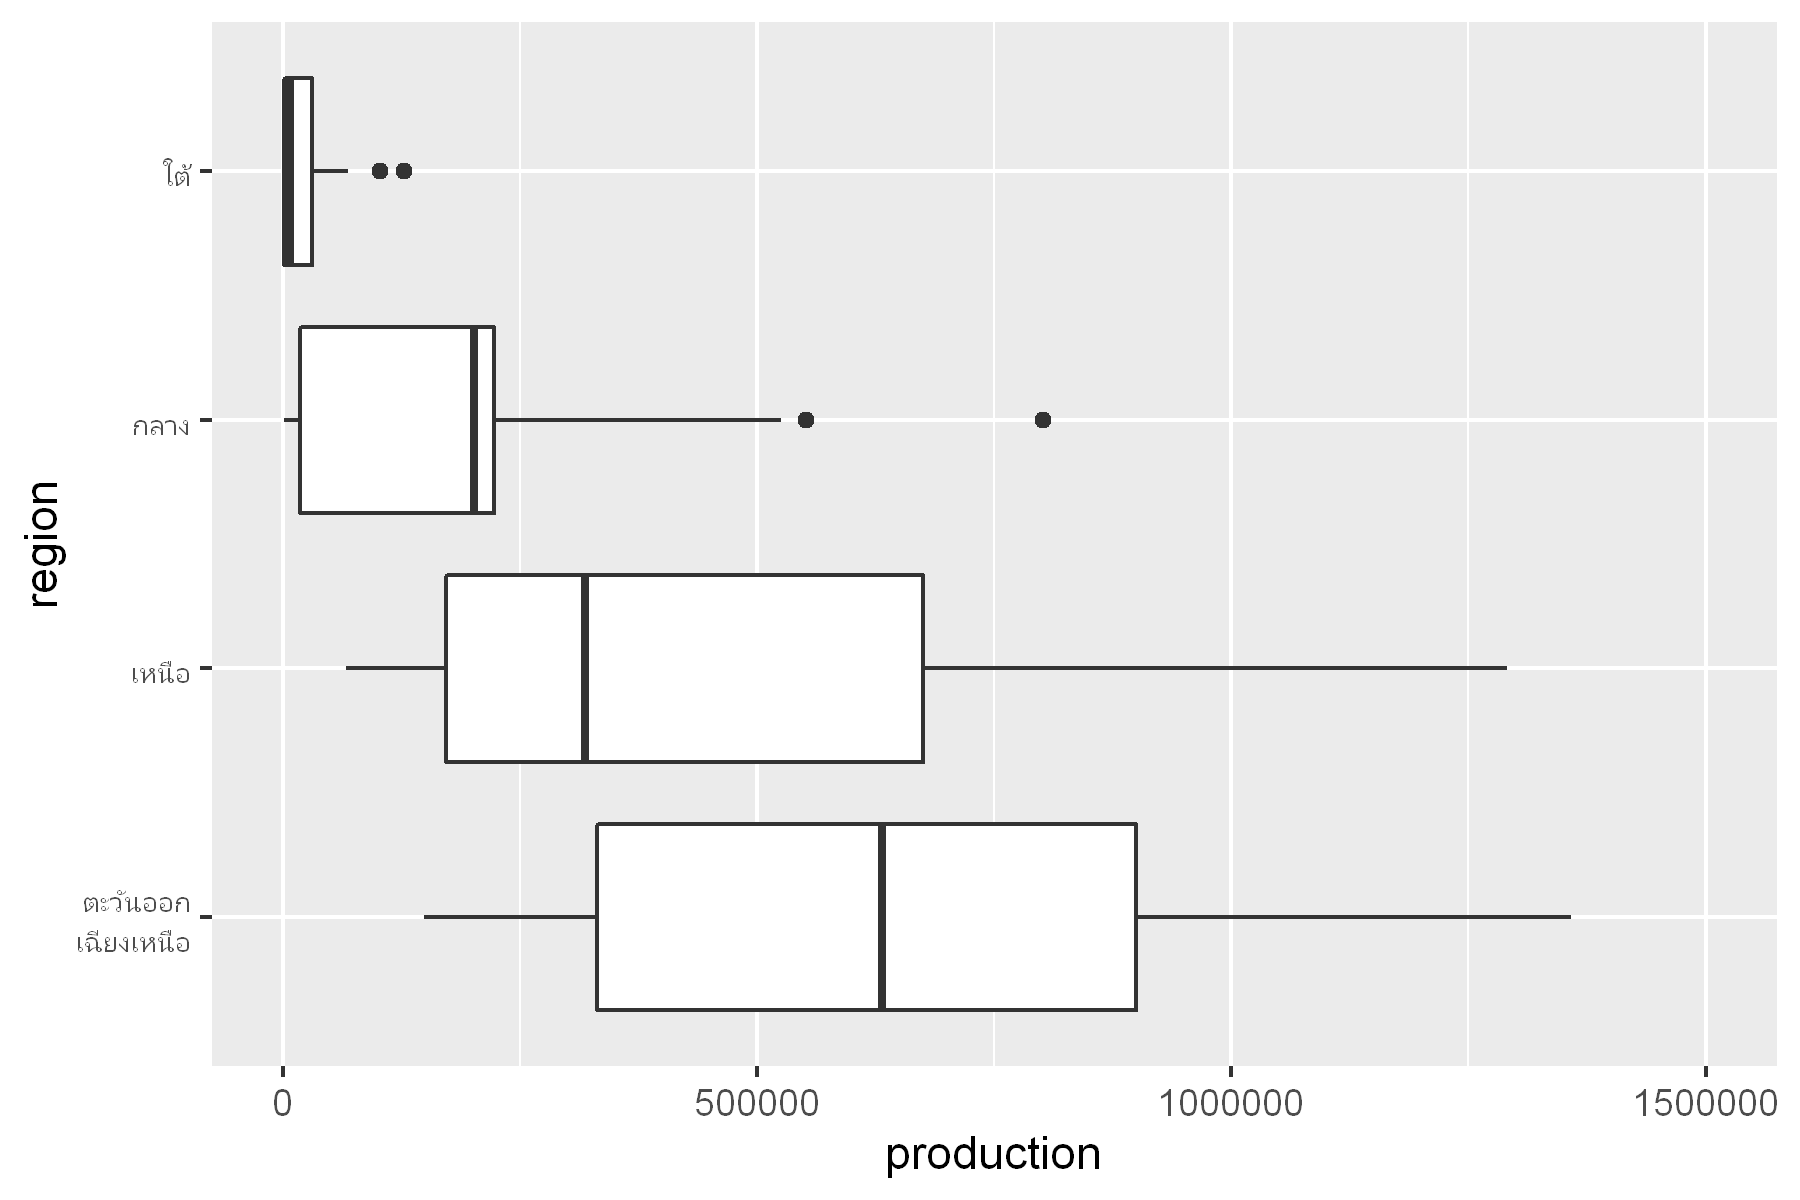

In [95]:
ggplot(df_sorted, aes(x = region, y = production)) +
  geom_boxplot() +
  coord_flip() +
  scale_y_continuous(limits = c(0, 15e5))

In [96]:
g <-
  ggplot(df_sorted, aes(x = region, y = production, color = region)) +
    coord_flip() +
    scale_y_comma(
      limits = c(0, 1.6e6), n.breaks = 3
    ) +
    scale_color_uchicago() +
    labs(x = NULL, y = "ปริมาณผลผลิต (ตัน)") + 
    theme(
      legend.position = "none",
      axis.title = element_text(size = 10),
      panel.grid = element_blank()
    )

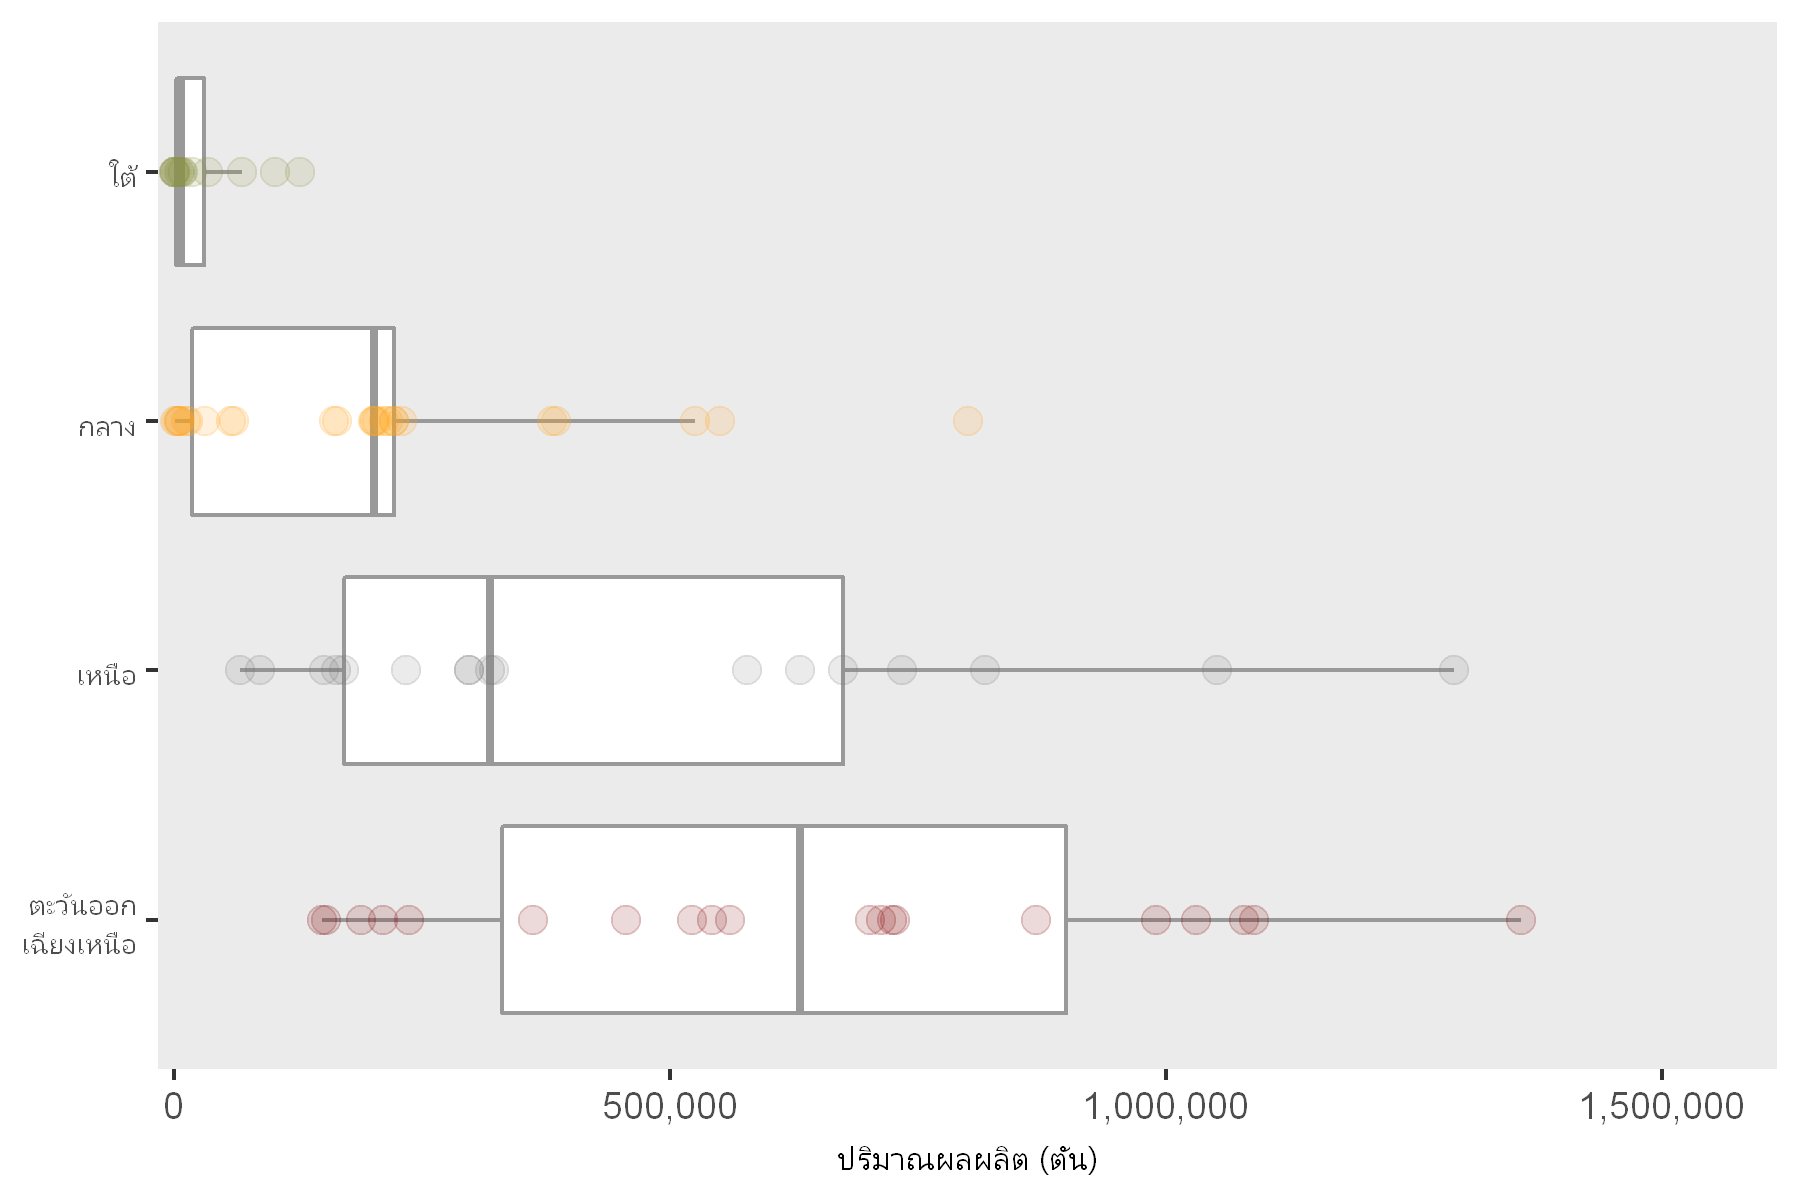

In [97]:
g + 
  geom_boxplot(color = "gray60", outlier.alpha = 0) +
  geom_point(size = 3, alpha = 0.15)

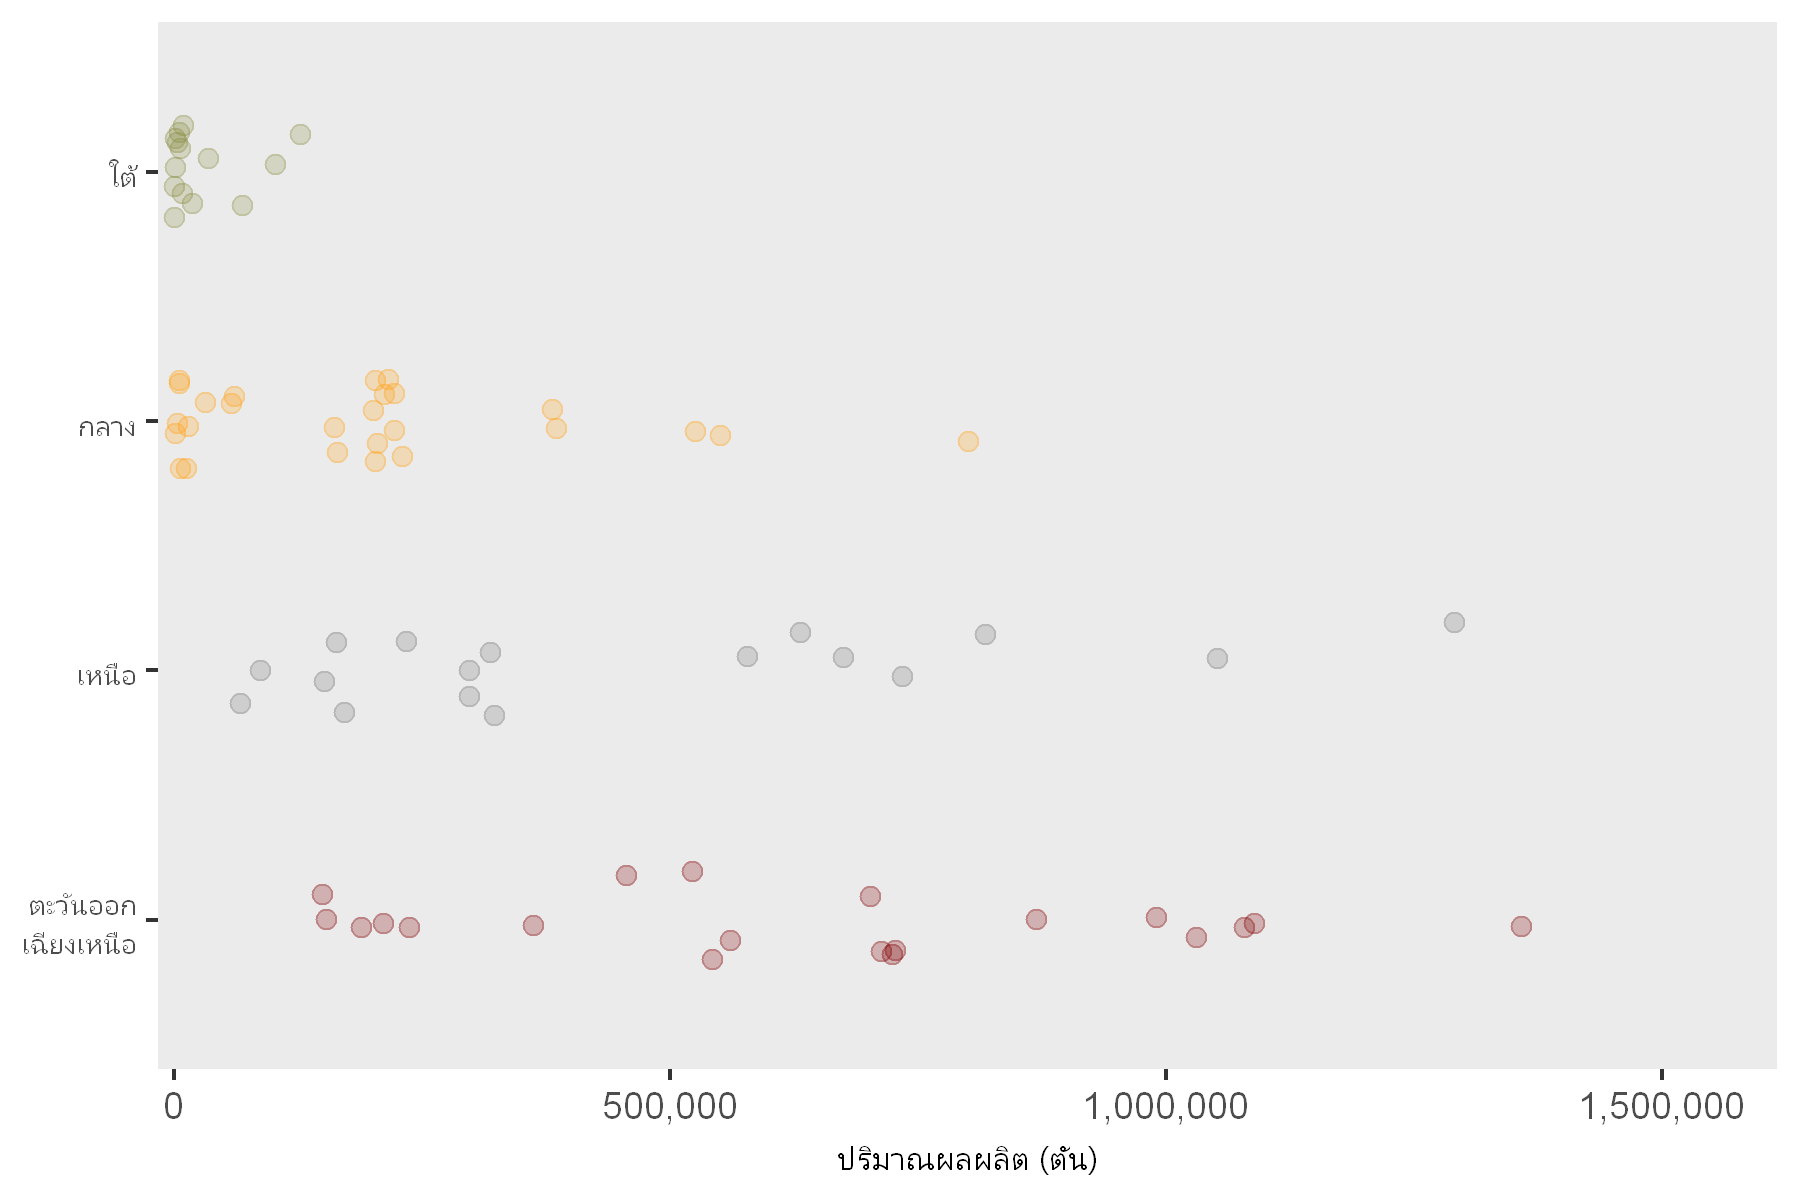

In [98]:
set.seed(123)

g + geom_jitter(size = 2, alpha = 0.25, width = 0.2)

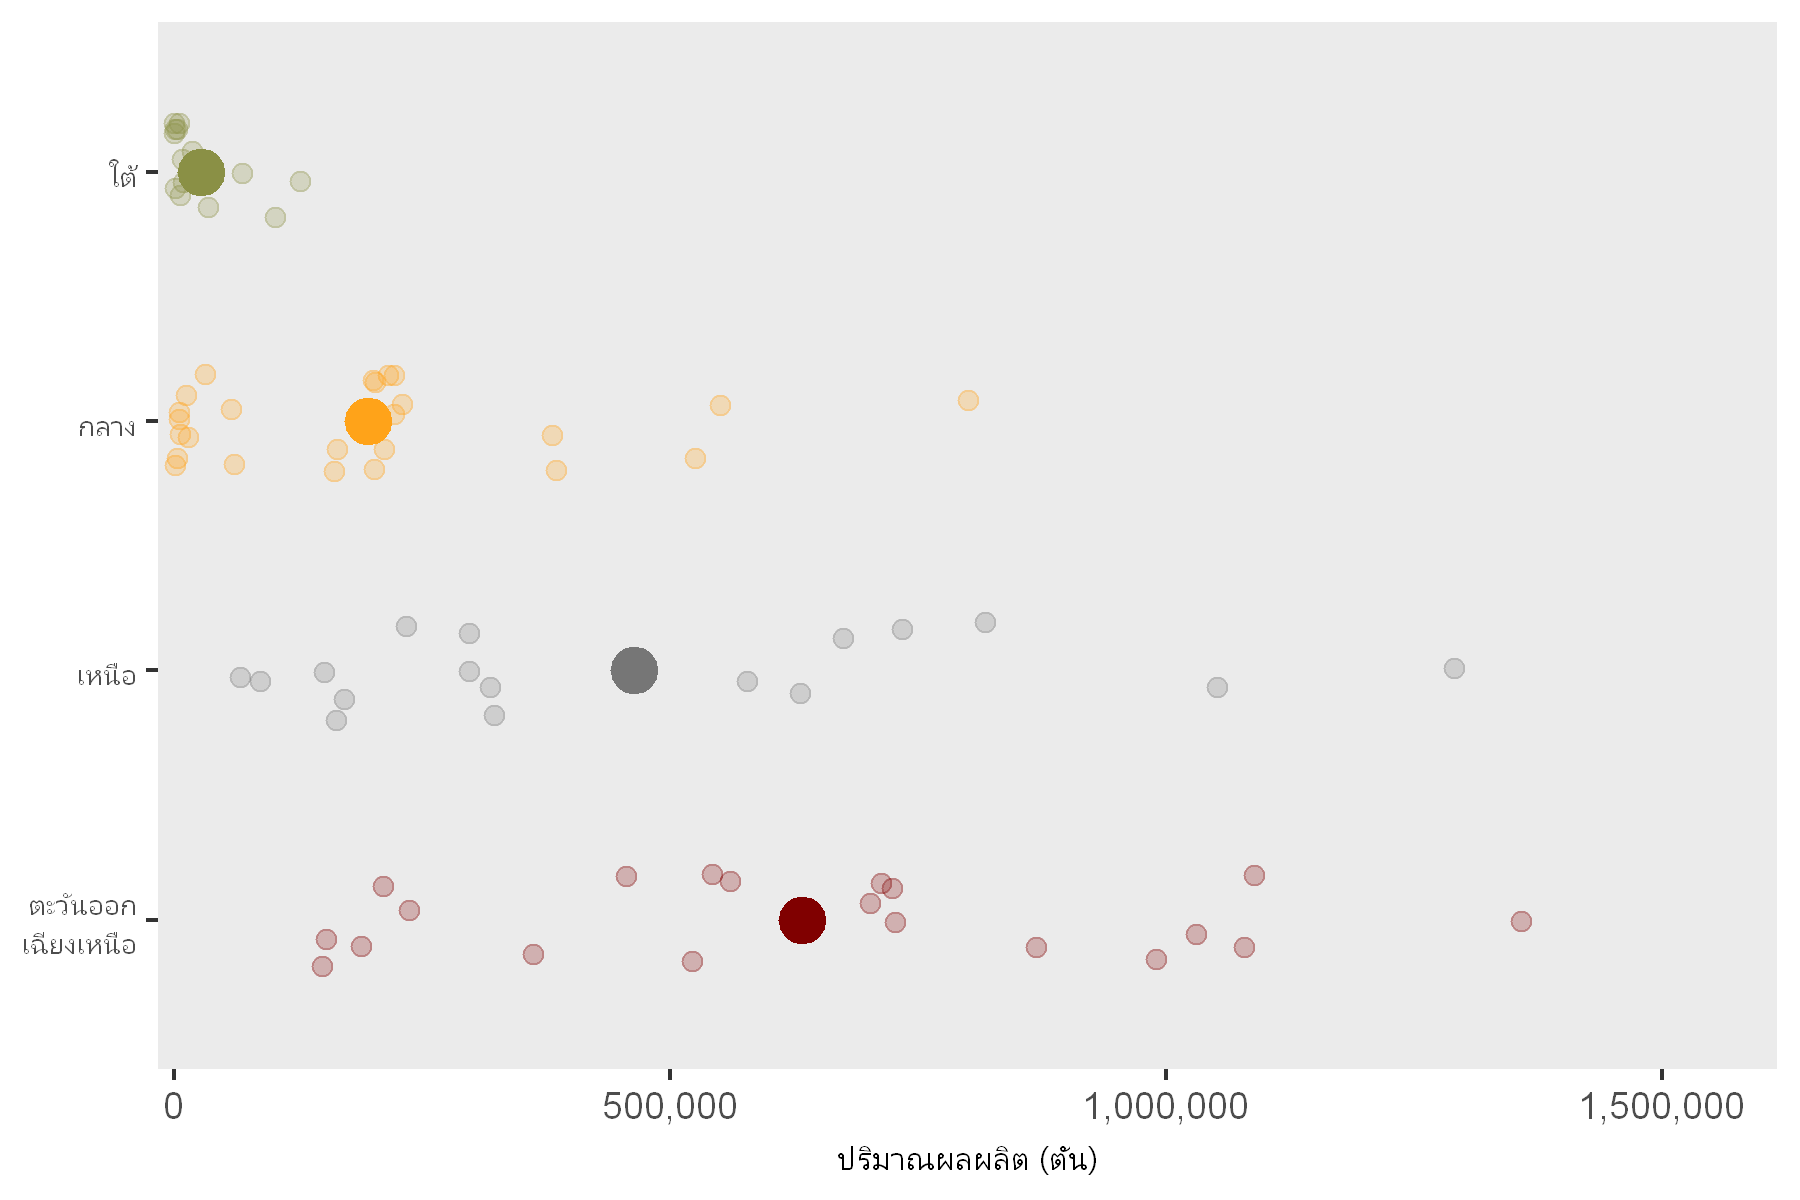

In [99]:
g +
  geom_jitter(size = 2, alpha = 0.25, width = 0.2) +
  stat_summary(fun = mean, geom = "point", size = 5)

In [100]:
tha_avg <-
  df_rice_major %>%
  summarize(avg = mean(production, na.rm = TRUE)) %>%
  pull(avg)

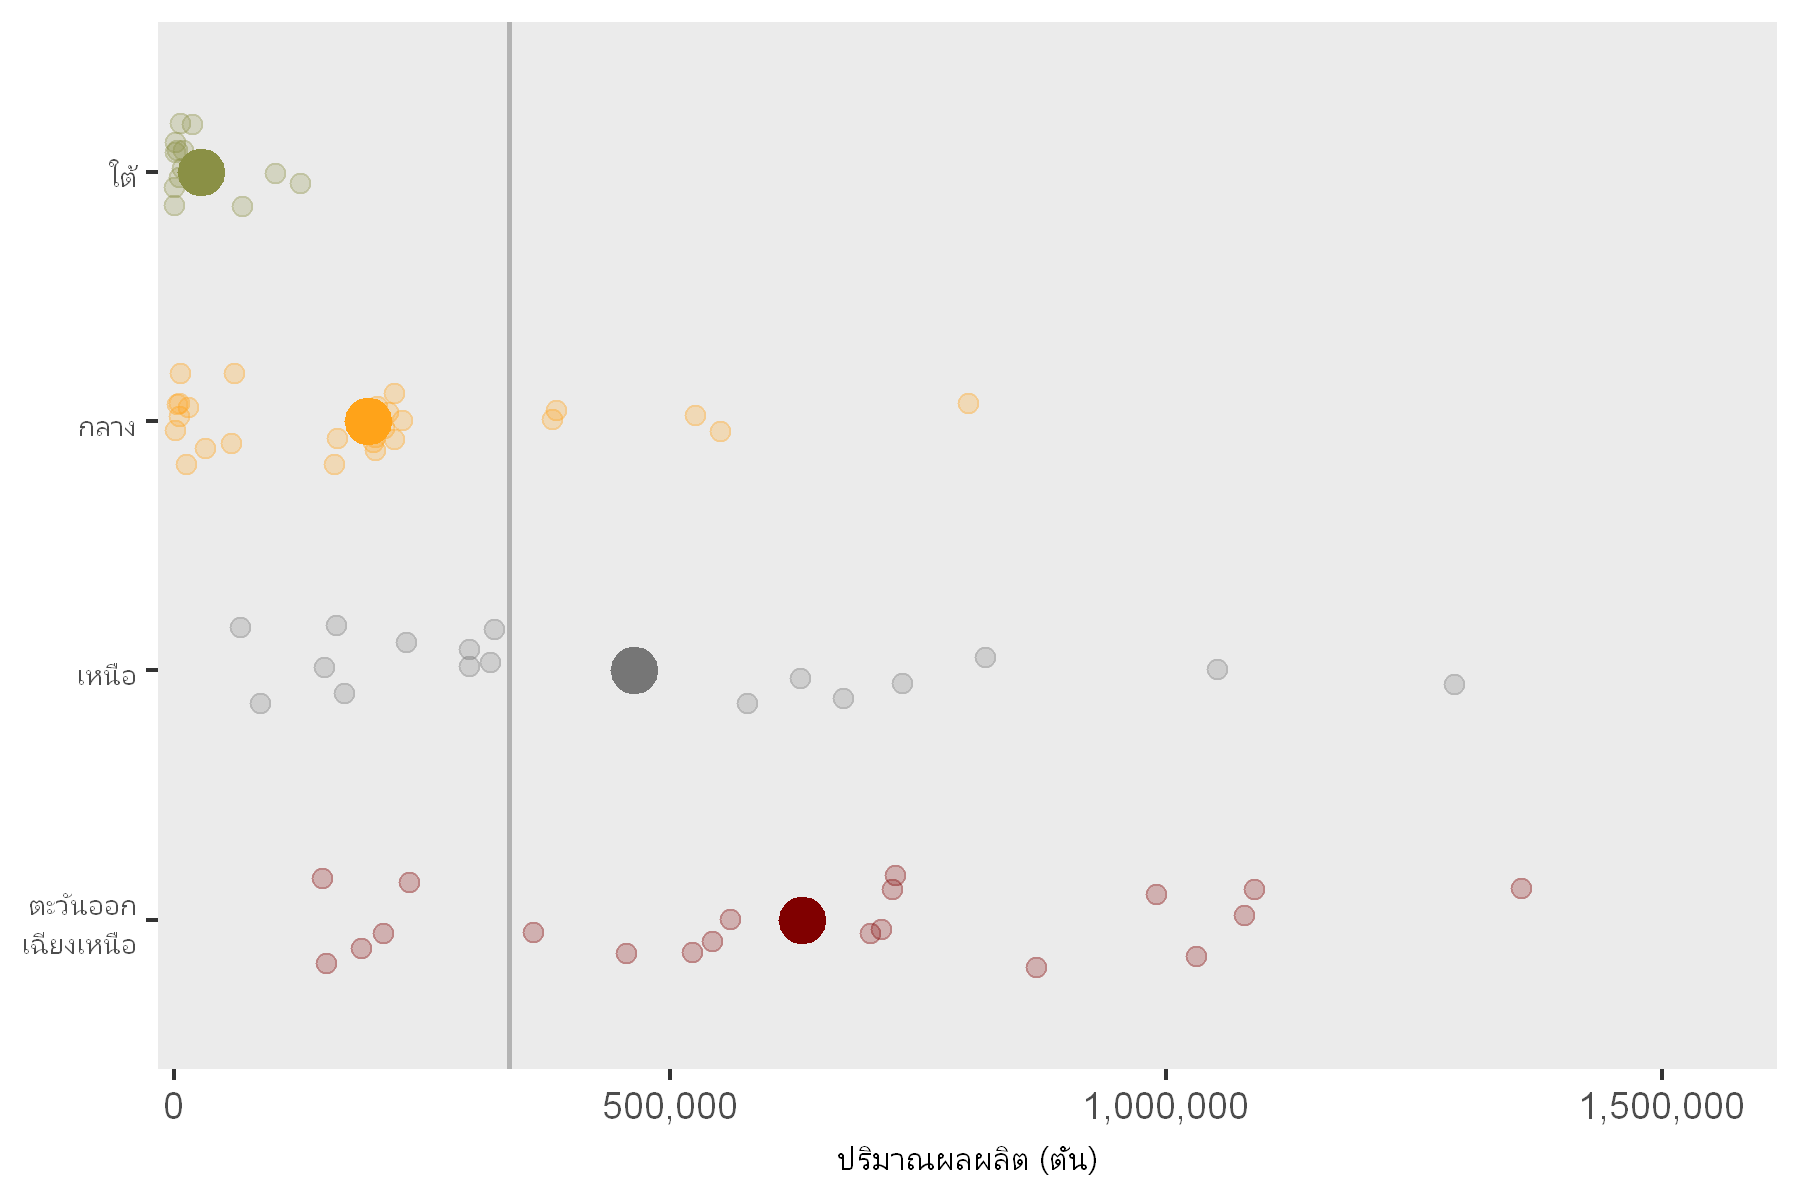

In [101]:
g +
  geom_hline(aes(yintercept = tha_avg), color = "gray70", size = 0.6) +
  stat_summary(fun = mean, geom = "point", size = 5) +
  geom_jitter(size = 2, alpha = 0.25, width = 0.2)

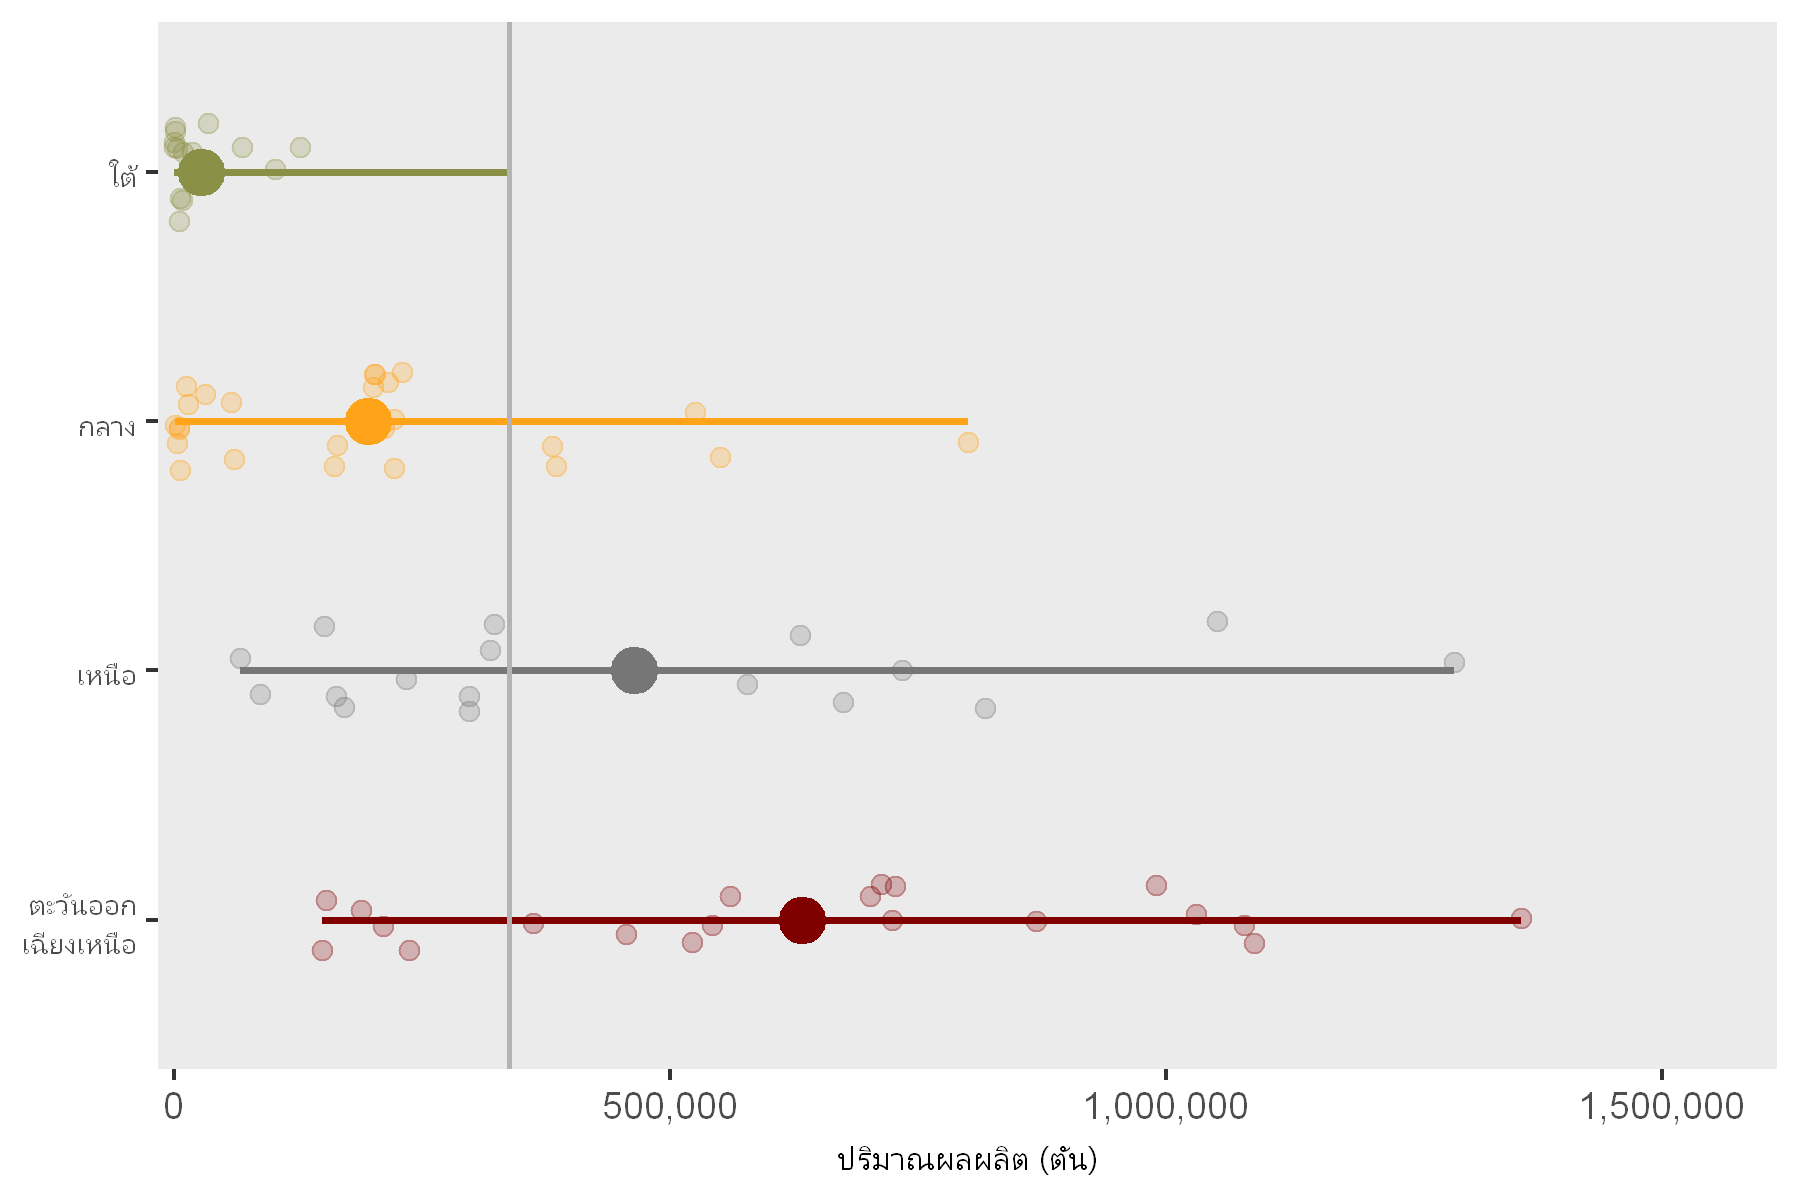

In [102]:
g +
  geom_segment(
    aes(x = region, xend = region,
        y = tha_avg, yend = production),
    size = 0.8
  ) +
  geom_hline(aes(yintercept = tha_avg), color = "gray70", size = 0.6) +
  geom_jitter(size = 2, alpha = 0.25, width = 0.2) +
  stat_summary(fun = mean, geom = "point", size = 5)

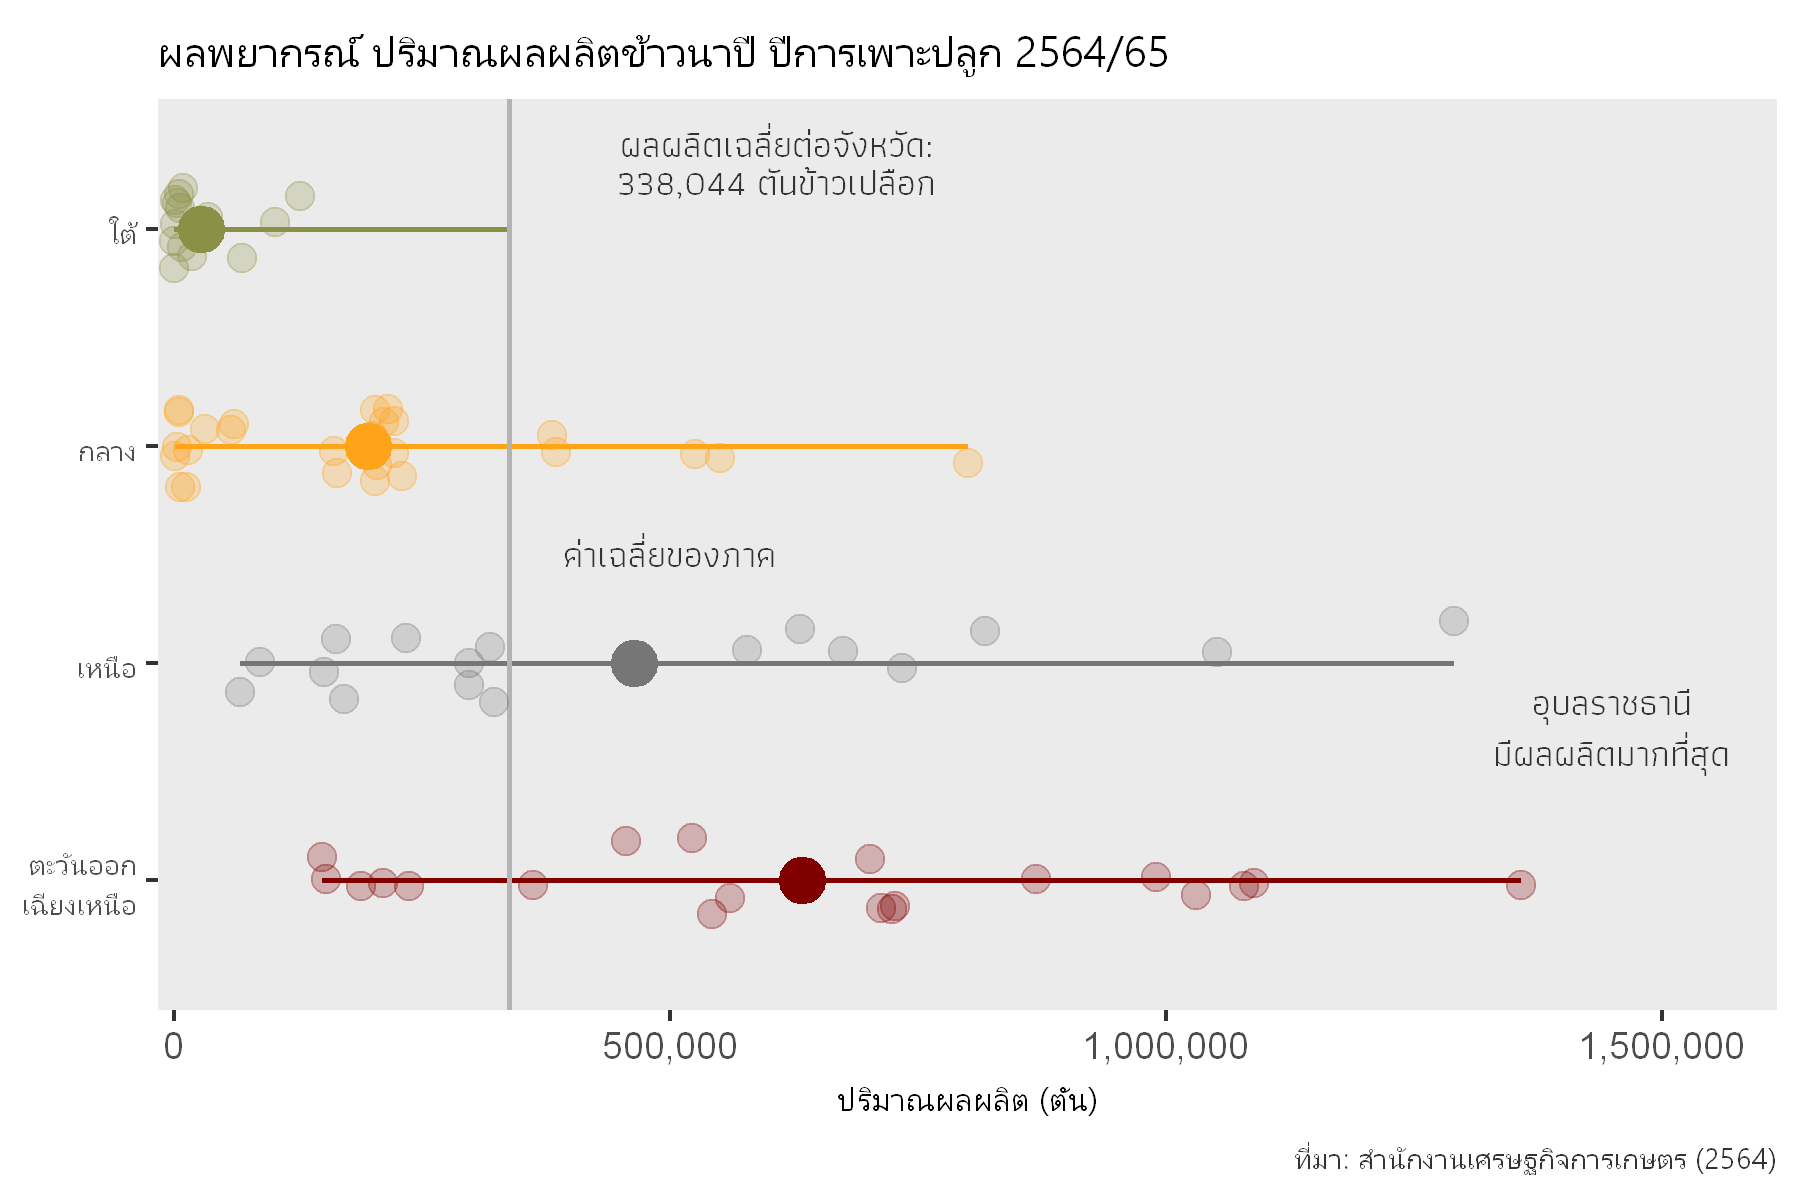

In [103]:
set.seed(123)
(g_text <-
  g +
  geom_segment(
    aes(x = region, xend = region,
        y = tha_avg, yend = production),
    size = 0.6
  ) +
  geom_hline(aes(yintercept = tha_avg), color = "gray70", size = 0.6) +
  geom_jitter(size = 3, alpha = 0.25, width = 0.2) +
  stat_summary(fun = mean, geom = "point", size = 5) +
  annotate(
    "text", x = 4.3, y = 1.8*round(tha_avg, 0), family = "Athiti", size = 3, color = "gray20", lineheight = .9,
    label = glue::glue("ผลผลิตเฉลี่ยต่อจังหวัด:\n{format(round(tha_avg, 0), big.mark=',')} ตันข้าวเปลือก")
  ) +
  annotate(
    "text", x = 2.5, y = 5e5, family = "Athiti", size = 3, color = "gray20",
    label = "ค่าเฉลี่ยของภาค"
  ) +
  annotate(
    "text", x = 1.7, y = 1.45e6, family = "Athiti", size = 3, color = "gray20",
    label = "อุบลราชธานี\nมีผลผลิตมากที่สุด"
  ) +
 labs(
   title = "ผลพยากรณ์ ปริมาณผลผลิตข้าวนาปี ปีการเพาะปลูก 2564/65",
   caption = "ที่มา: สำนักงานเศรษฐกิจการเกษตร (2564)"
 ) +
 theme(plot.caption = element_text(size = 9, color = "gray20"))
)

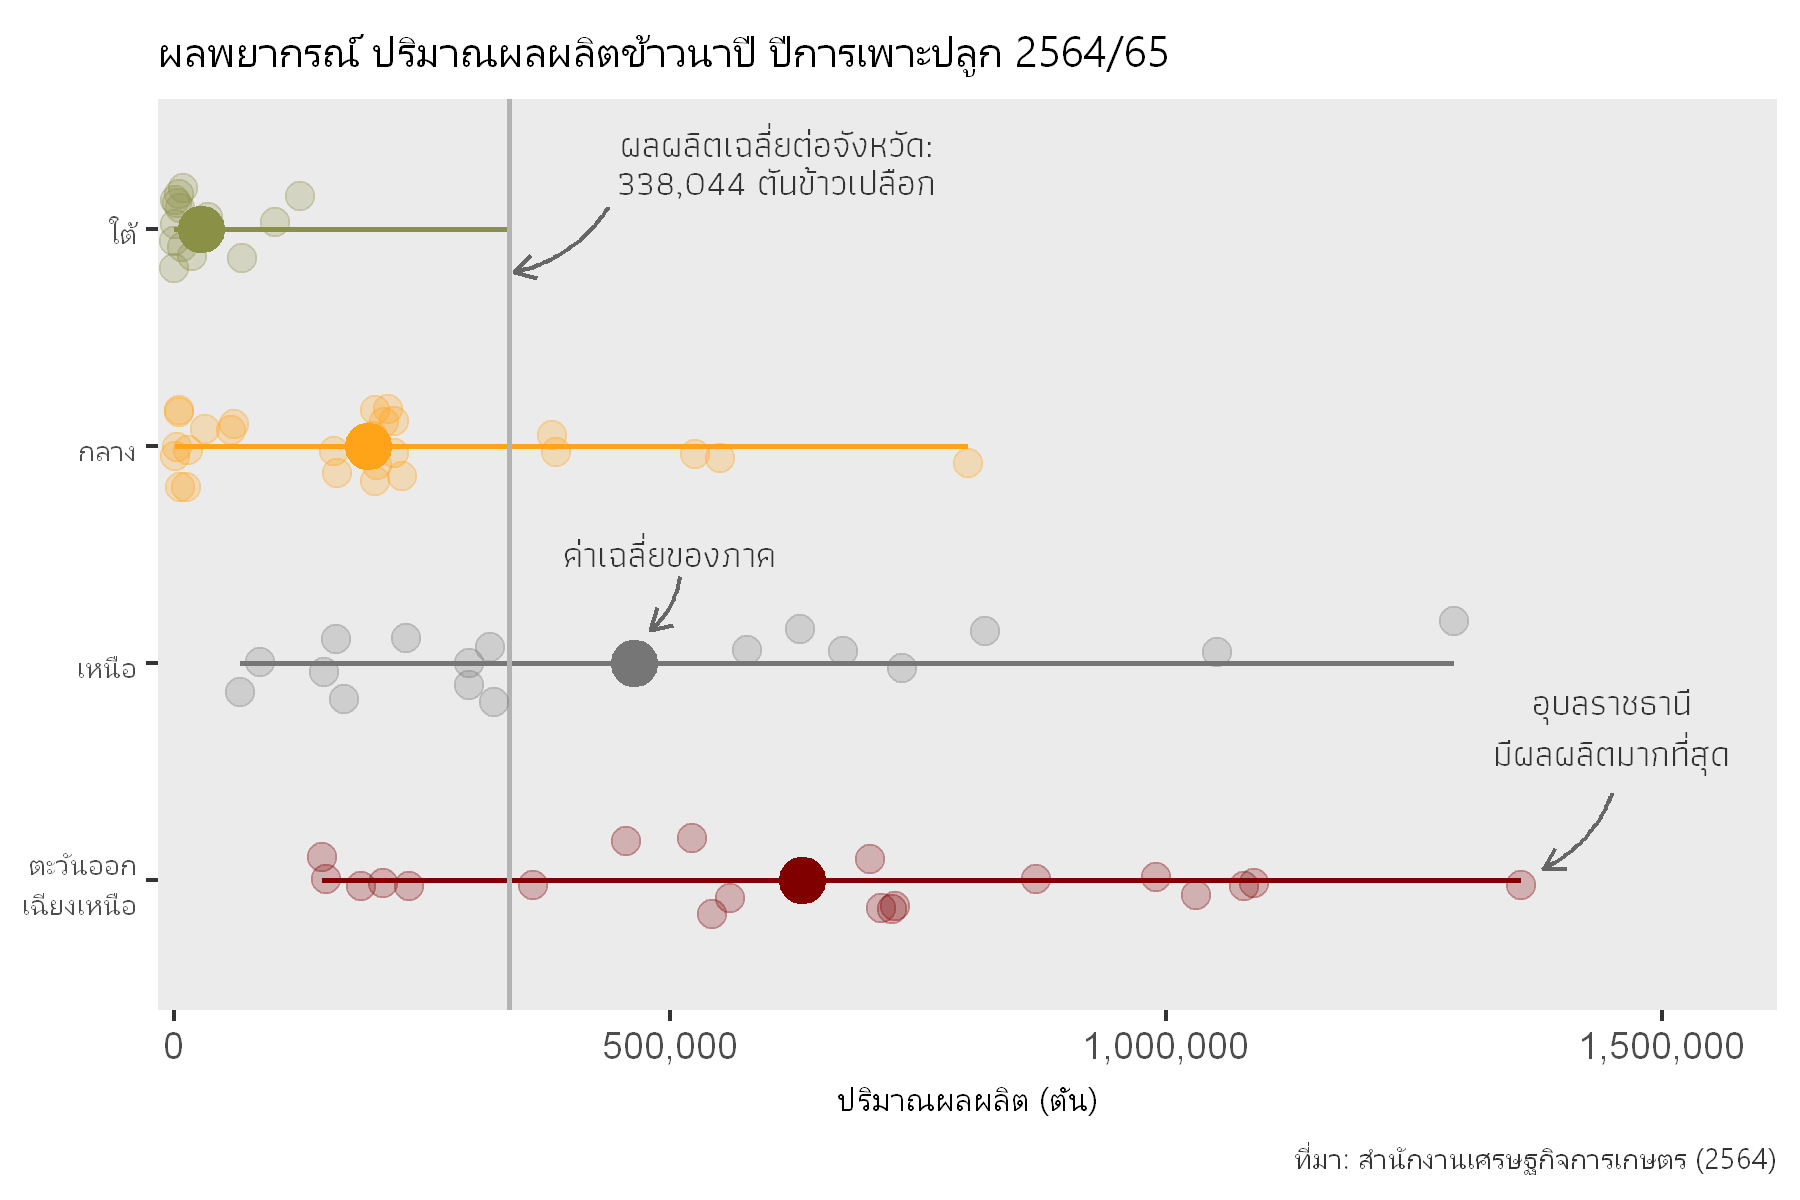

In [110]:
set.seed(123)
arrows <-
  tibble(
    x1 = c(4.1, 2.4, 1.4),
    x2 = c(3.8, 2.15, 1.05),
    y1 = c(tha_avg + 100000, 5.1e5, 1.45e6),
    y2 = c(tha_avg + 5000, 4.8e5, 1.38e6)
  )

(g_arrows <-
  g_text +
  geom_curve(
    data = arrows, aes(x = x1, y = y1, xend = x2, yend = y2),
    arrow = arrow(length = unit(0.08, "inch")), size = 0.5,
    color = "gray40", curvature = -0.2
  )
)

# Resources

- หนังสือ ggplot โดย Hadley Wickham ผู้สร้าง `ggplot` (https://ggplot2-book.org)
- หนังสือ R for Data Science โดย Hadley Wickham (https://r4ds.had.co.nz)
- A ggplot2 Tutorial for Beautiful Plotting in R by Cédric (https://www.cedricscherer.com/2019/08/05/a-ggplot2-tutorial-for-beautiful-plotting-in-r/)
- รวบรวม chart รูปแบบต่าง ๆ พร้อมวิธีการสร้างโดยใช้ R (https://www.r-graph-gallery.com)
- รวบรวม chart รูปแบบต่าง ๆ พร้อมแนวทางการเลือกงาน (https://www.data-to-viz.com)
- สอนการใช้ leaflet (https://rstudio.github.io/leaflet/)
- https://evamaerey.github.io/ggplot_flipbook/ggplot_flipbook_xaringan.html